In [ ]:
import os, shutil
from google.colab import drive

MOUNTPOINT = '/content/drive'

# 1) If it's not mounted but has leftovers, wipe the local folder
if not os.path.ismount(MOUNTPOINT):
    # remove any local files/dirs so mountpoint is empty
    shutil.rmtree(MOUNTPOINT, ignore_errors=True)
    os.makedirs(MOUNTPOINT, exist_ok=True)

# 2) Mount
drive.mount(MOUNTPOINT)
print('✅ Mounted at', MOUNTPOINT)


Mounted at /content/drive
✅ Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
"""
STUDENT PLM (BERT) with FCM head
- Consumes 'student_input' paragraphs with a single masked query clause.
- Query markers: [unused1] ... [unused2] (safe, single-token in BERT).
  If your CSV still has <s> ... </s>, we convert them on the fly.
- Head: FCM (3*H -> H -> num_labels) and initialized from TEACHER (RoBERTa) head.
- Freezes first 8 encoder blocks of BERT (paper-style).
"""

# 1) Install libs (Colab)
!pip -q install transformers datasets evaluate safetensors

# 2) Imports & Drive
import os, re, json, math
import torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, AutoConfig
import evaluate



# 3) Config
BASE_DIR   = "/content/drive/MyDrive/MELD"
TRAIN_CSV  = os.path.join(BASE_DIR, "train_for_student_paragraph.csv")  # from your builder
DEV_CSV    = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")
OUT_DIR    = os.path.join(BASE_DIR, "student_bert_fcm")
TEACH_DIR  = os.path.join(BASE_DIR, "teacher_roberta_fg_head_marked")   # where model.safetensors lives

MODEL_NAME = "bert-base-uncased"
EMOTIONS   = ["anger","disgust","fear","joy","neutral","sadness","surprise"]
label2id   = {e:i for i,e in enumerate(EMOTIONS)}
id2label   = {i:e for e,i in label2id.items()}

MAX_LEN    = 256
BATCH_T    = 16
BATCH_E    = 32
EPOCHS     = 4
LR         = 2e-5
WD         = 0.01
SEED       = 42

Q_OPEN, Q_CLOSE = "[unused1]", "[unused2]"    # markers for the QUERY region
os.makedirs(OUT_DIR, exist_ok=True)

# 4) Load data (and normalize markers if needed)
df_train = pd.read_csv(TRAIN_CSV)
df_dev   = pd.read_csv(DEV_CSV)

assert {"student_input","Emotion"}.issubset(df_train.columns)
assert {"student_input","Emotion"}.issubset(df_dev.columns)

def normalize_markers(s: str) -> str:
    # If the builder used <s>...</s>, convert to [unused1]/[unused2] for BERT.
    s = re.sub(r"<\s*s\s*>", Q_OPEN, str(s))
    s = re.sub(r"<\s*/\s*s\s*>", Q_CLOSE, s)
    return s

df_train["student_input"] = df_train["student_input"].map(normalize_markers)
df_dev["student_input"]   = df_dev["student_input"].map(normalize_markers)

# 5) Tokenizer (BERT) + IDs for markers
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
ID_OPEN   = tokenizer.convert_tokens_to_ids(Q_OPEN)
ID_CLOSE  = tokenizer.convert_tokens_to_ids(Q_CLOSE)

# 6) Build FCM masks from markers
def masks_from_markers(ids, am, id_open=ID_OPEN, id_close=ID_CLOSE):
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(id_open)  if id_open  in ids else None
    e = ids.index(id_close) if id_close in ids else None
    if s is None or e is None or e <= s:
        # Fallback: treat everything visible as QUERY if markers missing/truncated
        for i in range(T):
            if am[i]==1: qm[i]=1
        return pm,qm,fm
    for i in range(0, s):
        if am[i]==1: pm[i]=1
    for i in range(s+1, e):
        if am[i]==1: qm[i]=1
    for i in range(e+1, T):
        if am[i]==1: fm[i]=1
    return pm,qm,fm

def encode_batch(batch):
    enc = tokenizer(
        batch["student_input"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )
    enc["labels"] = [label2id[x] for x in batch["Emotion"]]
    pm_list, qm_list, fm_list = [], [], []
    for ids, am in zip(enc["input_ids"], enc["attention_mask"]):
        pm, qm, fm = masks_from_markers(ids, am)
        pm_list.append(pm); qm_list.append(qm); fm_list.append(fm)
    enc["past_mask"]   = pm_list
    enc["query_mask"]  = qm_list
    enc["future_mask"] = fm_list
    return enc

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train[["student_input","Emotion"]].copy(), preserve_index=False),
    "validation": Dataset.from_pandas(df_dev[["student_input","Emotion"]].copy(), preserve_index=False),
})
encoded = ds.map(encode_batch, batched=True, remove_columns=ds["train"].column_names)
encoded.set_format(type="torch")

# 7) BERT + FCM head
class FineGrainedHead(nn.Module):
    def __init__(self, hidden, proj=768, num_labels=7, pdrop=0.1):
        super().__init__()
        self.proj = nn.Linear(3*hidden, hidden)  # mirror teacher's fc1: 3H -> H
        self.tanh = nn.Tanh()
        self.drop = nn.Dropout(pdrop)
        self.out  = nn.Linear(hidden, num_labels) # mirror teacher's fc2: H -> C
    def forward(self, Fp, Fq, Ff):
        Z = torch.cat([Fp, Fq, Ff], dim=-1)   # [B, 3H]
        H = self.drop(self.tanh(self.proj(Z)))
        return self.out(H)

def mean_pool(L, mask_bool):
    # L: [B,T,H], mask_bool: [B,T]
    lens  = mask_bool.sum(dim=1).clamp(min=1).unsqueeze(-1)  # [B,1]
    summed= (L * mask_bool.unsqueeze(-1)).sum(dim=1)         # [B,H]
    return summed / lens

class BERTWithFCM(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=len(EMOTIONS)):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden = self.bert.config.hidden_size  # 768
        self.head   = FineGrainedHead(
            hidden=self.hidden,
            proj=self.hidden,
            num_labels=num_labels,
            pdrop=self.bert.config.hidden_dropout_prob
        )
    def forward(self, input_ids, attention_mask, past_mask, query_mask, future_mask, labels=None):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        L = out.last_hidden_state
        Fp = mean_pool(L, past_mask.bool())
        Fq = mean_pool(L, query_mask.bool())
        Ff = mean_pool(L, future_mask.bool())
        logits = self.head(Fp, Fq, Ff)
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

model = BERTWithFCM(model_name=MODEL_NAME, num_labels=len(EMOTIONS))

# 8) Initialize student head from TEACHER (RoBERTa FG head)
def load_teacher_state_dict(ckpt_dir):
    bin_path  = os.path.join(ckpt_dir, "pytorch_model.bin")
    safe_path = os.path.join(ckpt_dir, "model.safetensors")
    if os.path.exists(bin_path):
        return torch.load(bin_path, map_location="cpu")
    elif os.path.exists(safe_path):
        from safetensors.torch import load_file
        return load_file(safe_path)
    else:
        raise FileNotFoundError(f"No weights found in {ckpt_dir}")

try:
    t_sd = load_teacher_state_dict(TEACH_DIR)
    # Teacher keys are like "head.fc1.weight", "head.fc2.bias"
    with torch.no_grad():
        model.head.proj.weight.copy_(t_sd["head.fc1.weight"])
        model.head.proj.bias.copy_(t_sd["head.fc1.bias"])
        # copy final layer only if num_labels matches (7)
        if model.head.out.weight.shape == t_sd["head.fc2.weight"].shape:
            model.head.out.weight.copy_(t_sd["head.fc2.weight"])
            model.head.out.bias.copy_(t_sd["head.fc2.bias"])
    print("✓ Loaded teacher FG head into student.")
except Exception as e:
    print("⚠️ Could not load teacher head weights — training head from scratch. Reason:", e)

# 9) Freeze first 8 BERT layers
def freeze_first_n_layers_bert(model, n=8, freeze_embeddings=False):
    backbone = getattr(model, "bert", None)
    if backbone is None:
        raise ValueError("Expected model.bert backbone.")
    if freeze_embeddings and hasattr(backbone, "embeddings"):
        for p in backbone.embeddings.parameters():
            p.requires_grad = False
    enc = backbone.encoder
    total_layers = len(enc.layer)
    n = min(n, total_layers)
    for i in range(n):
        for p in enc.layer[i].parameters():
            p.requires_grad = False
    print(f"🔒 Froze BERT encoder blocks [0..{n-1}] / {total_layers}")

freeze_first_n_layers_bert(model, n=8, freeze_embeddings=False)

# 10) Metrics
acc = evaluate.load("accuracy")
f1w = evaluate.load("f1")

def compute_metrics(p):
    y_pred = p.predictions.argmax(-1)
    y_true = p.label_ids
    return {
        "accuracy": acc.compute(predictions=y_pred, references=y_true)["accuracy"],
        "f1_weighted": f1w.compute(predictions=y_pred, references=y_true, average="weighted")["f1"],
        "f1_macro": f1w.compute(predictions=y_pred, references=y_true, average="macro")["f1"],
    }

# 11) Trainer (with robust compute_loss signature)
args = TrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WD,
    per_device_train_batch_size=BATCH_T,
    per_device_eval_batch_size=BATCH_E,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to=["none"],
    seed=SEED,
)

class FCMTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs["logits"]
        loss    = F.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = FCMTrainer(
    model=model,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 12) Train & save
trainer.train()
trainer.save_model(os.path.join(OUT_DIR, "student_bert_fcm"))
tokenizer.save_pretrained(os.path.join(OUT_DIR, "student_bert_fcm"))

print("✅ Student (BERT+FCM) finished. Saved to:", os.path.join(OUT_DIR, "student_bert_fcm"))

# 13) Eval
print(trainer.evaluate())


Map:   0%|          | 0/9988 [00:00<?, ? examples/s]

Map:   0%|          | 0/1108 [00:00<?, ? examples/s]

✓ Loaded teacher FG head into student.
🔒 Froze BERT encoder blocks [0..7] / 12


/tmp/ipython-input-2263538713.py:233: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FCMTrainer.__init__`. Use `processing_class` instead.
  trainer = FCMTrainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
!pip -q install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Loaded weights. Missing: [] Unexpected: []
[LIME] processed 25/250
[LIME] processed 50/250
[LIME] processed 75/250
[LIME] processed 100/250
[LIME] processed 125/250
[LIME] processed 150/250
[LIME] processed 175/250
[LIME] processed 200/250
[LIME] processed 225/250
[LIME] processed 250/250
✓ Saved CSV: /content/drive/MyDrive/MELD/explain/lime_aggregated_tokens.csv
✓ Saved plot: /content/drive/MyDrive/MELD/explain/lime_aggregated_barplot.png


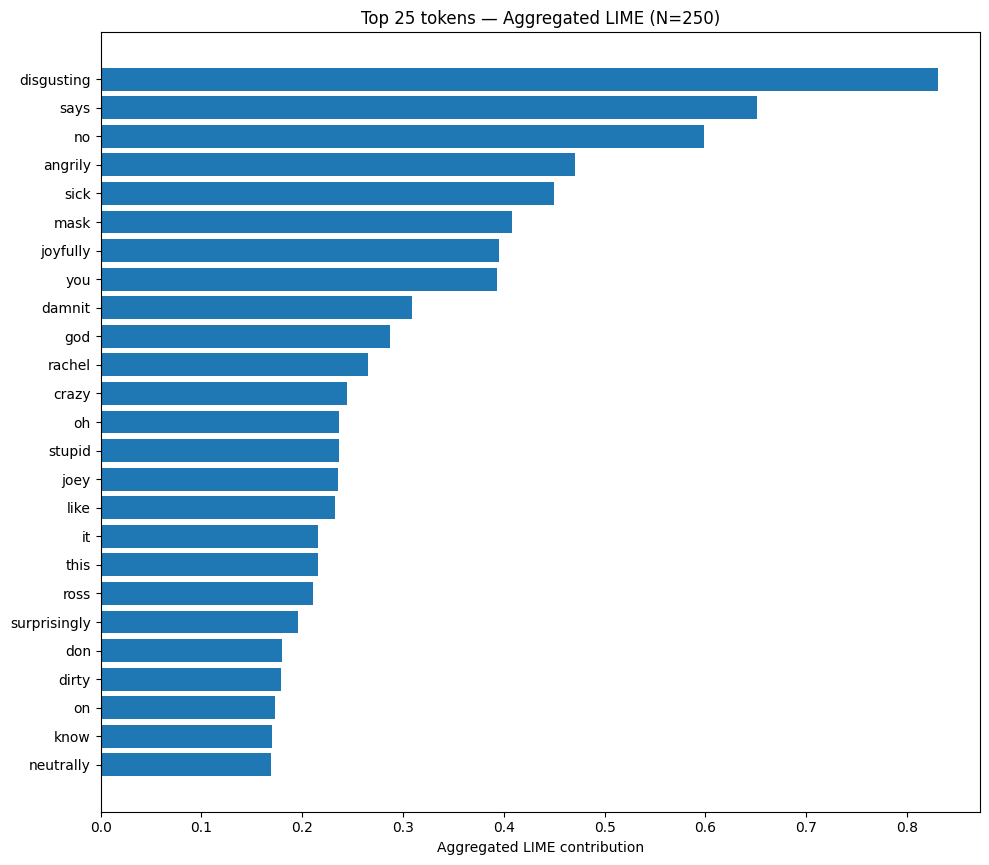

In [ ]:
# Aggregated LIME for student BERT+FCM — single self-contained cell

!pip -q install lime safetensors

import os, re, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModel

# ----- CONFIG -----
BASE_DIR      = "/content/drive/MyDrive/MELD"
CSV_PATH      = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")   # or train_for_student_paragraph.csv
MODEL_DIR     = os.path.join("/content/drive/MyDrive/MELD/student_bert_fcm/student_bert_fcm")                # folder where you saved the student
MODEL_NAME    = "bert-base-uncased"

NUM_UTTERANCES       = 250    # how many examples to explain (<=0 => all)
MAX_SAMPLES_PER_UTT  = 200    # LIME samples per explanation (tradeoff speed/stability)
TOP_FEATURES_PER_EXP = 10     # how many tokens to keep per explanation
USE_ABS              = True   # aggregate absolute contribution
LOWERCASE_TOKENS     = True
MIN_TOKEN_LEN        = 2
BAR_TOP_K            = 25
SEED                 = 42
MAX_LEN              = 256

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Minimal student model (BERT + FCM head) -----
def mean_pool(L, mask_bool):
    lens = mask_bool.sum(dim=1).clamp(min=1).unsqueeze(-1)
    return (L * mask_bool.unsqueeze(-1)).sum(dim=1) / lens

class FineGrainedHead(nn.Module):
    def __init__(self, hidden, proj=None, num_labels=7, pdrop=0.1):
        super().__init__()
        if proj is None: proj = hidden
        self.proj = nn.Linear(3*hidden, proj)  # 3H -> H
        self.tanh = nn.Tanh()
        self.drop = nn.Dropout(pdrop)
        self.out  = nn.Linear(proj, num_labels) # H -> C
    def forward(self, Fp, Fq, Ff):
        Z = torch.cat([Fp, Fq, Ff], dim=-1)
        H = self.drop(self.tanh(self.proj(Z)))
        return self.out(H)

class BERTWithFCM(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=7):
        super().__init__()
        self.bert   = AutoModel.from_pretrained(model_name)
        self.hidden = self.bert.config.hidden_size  # 768
        self.head   = FineGrainedHead(
            hidden=self.hidden, proj=self.hidden,
            num_labels=num_labels, pdrop=self.bert.config.hidden_dropout_prob
        )
    def forward(self, input_ids, attention_mask, past_mask, query_mask, future_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        L   = out.last_hidden_state
        Fp  = mean_pool(L, past_mask.bool())
        Fq  = mean_pool(L, query_mask.bool())
        Ff  = mean_pool(L, future_mask.bool())
        logits = self.head(Fp, Fq, Ff)
        return logits

# ----- Load model + weights -----
model = BERTWithFCM(model_name=MODEL_NAME, num_labels=7)
bin_path  = os.path.join(MODEL_DIR, "pytorch_model.bin")
safe_path = os.path.join(MODEL_DIR, "model.safetensors")
if os.path.exists(bin_path):
    state = torch.load(bin_path, map_location="cpu")
elif os.path.exists(safe_path):
    from safetensors.torch import load_file
    state = load_file(safe_path)
else:
    raise FileNotFoundError(f"No model weights found in {MODEL_DIR}")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded weights. Missing:", missing, "Unexpected:", unexpected)
model.eval().to(device)

# ----- Data -----
df = pd.read_csv(CSV_PATH)
assert {"student_input","Emotion"}.issubset(df.columns)
texts = df["student_input"].astype(str).tolist()
if NUM_UTTERANCES and NUM_UTTERANCES > 0:
    texts = texts[:NUM_UTTERANCES]

# ----- Tokenizer + FCM markers -----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
Q_OPEN, Q_CLOSE = "[unused1]", "[unused2]"
ID_OPEN  = tokenizer.convert_tokens_to_ids(Q_OPEN)
ID_CLOSE = tokenizer.convert_tokens_to_ids(Q_CLOSE)

def masks_from_markers(ids, am, id_open=ID_OPEN, id_close=ID_CLOSE):
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(id_open)  if id_open  in ids else None
    e = ids.index(id_close) if id_close in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
        return pm,qm,fm
    for i in range(0, s):
        if am[i]==1: pm[i]=1
    for i in range(s+1, e):
        if am[i]==1: qm[i]=1
    for i in range(e+1, T):
        if am[i]==1: fm[i]=1
    return pm,qm,fm

@torch.no_grad()
def predict_proba(text_list):
    enc = tokenizer(text_list, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    pm_list, qm_list, fm_list = [], [], []
    for ids, am in zip(enc["input_ids"].tolist(), enc["attention_mask"].tolist()):
        pm,qm,fm = masks_from_markers(ids, am)
        pm_list.append(pm); qm_list.append(qm); fm_list.append(fm)
    enc["past_mask"]   = torch.tensor(pm_list)
    enc["query_mask"]  = torch.tensor(qm_list)
    enc["future_mask"] = torch.tensor(fm_list)
    for k in enc:
        enc[k] = enc[k].to(device)

    # Remove token_type_ids as it's not a parameter in the model's forward method
    if "token_type_ids" in enc:
        del enc["token_type_ids"]

    logits = model(**enc)                   # [B,7]
    probs  = F.softmax(logits, dim=-1).cpu().numpy()
    return probs

# ----- LIME -----
CLASS_NAMES = ["anger","disgust","fear","joy","neutral","sadness","surprise"]
explainer = LimeTextExplainer(class_names=CLASS_NAMES)

def norm_token(t):
    t = t.strip()
    return t.lower() if LOWERCASE_TOKENS else t

agg = {}
for i, text in enumerate(texts):
    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=predict_proba,
        num_features=TOP_FEATURES_PER_EXP,
        num_samples=MAX_SAMPLES_PER_UTT
    )
    for tok, w in exp.as_list():
        tok = norm_token(tok)
        if len(tok) < MIN_TOKEN_LEN:
            continue
        agg[tok] = agg.get(tok, 0.0) + (abs(w) if USE_ABS else w)
    if (i+1) % 25 == 0:
        print(f"[LIME] processed {i+1}/{len(texts)}")

# ----- Save CSV + Plot -----
os.makedirs(os.path.join(BASE_DIR, "explain"), exist_ok=True)
agg_df  = pd.DataFrame(sorted(agg.items(), key=lambda x: x[1], reverse=True), columns=["token","agg_contribution"])
csv_out = os.path.join(BASE_DIR, "explain", "lime_aggregated_tokens.csv")
png_out = os.path.join(BASE_DIR, "explain", "lime_aggregated_barplot.png")
agg_df.to_csv(csv_out, index=False)
print("✓ Saved CSV:", csv_out)

top = agg_df.head(BAR_TOP_K)
plt.figure(figsize=(10, max(4, 0.35*len(top))))
plt.barh(top["token"][::-1], top["agg_contribution"][::-1])
plt.xlabel("Aggregated LIME contribution")
plt.title(f"Top {len(top)} tokens — Aggregated LIME (N={len(texts)})")
plt.tight_layout()
plt.savefig(png_out, dpi=150)
print("✓ Saved plot:", png_out)

LIME explaining (all emotions):   0%|          | 0/250 [00:00<?, ?it/s]

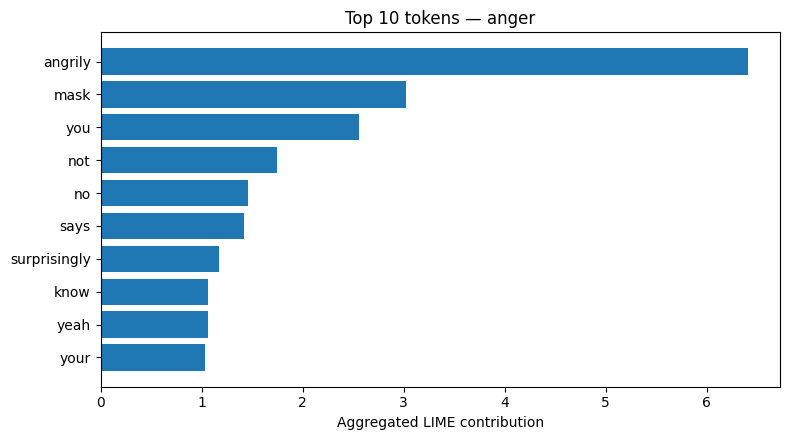

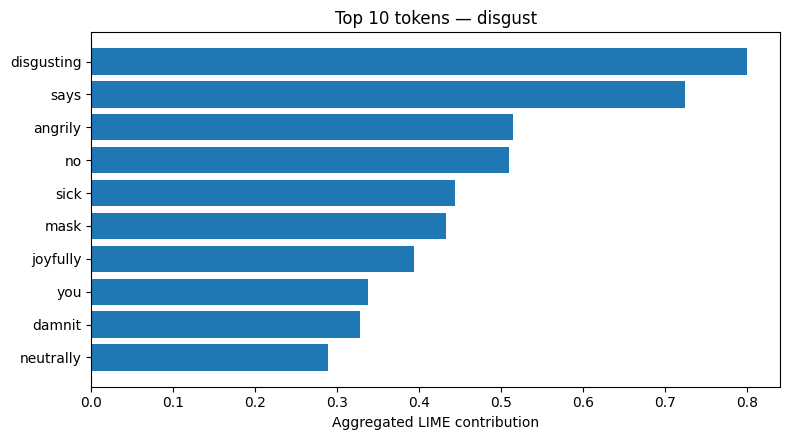

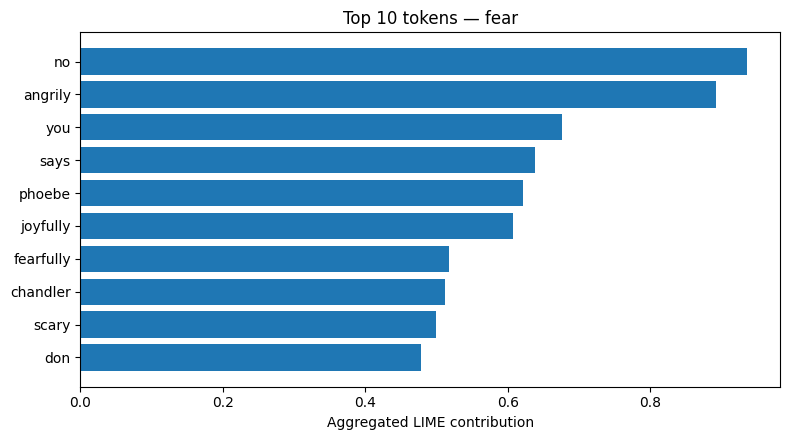

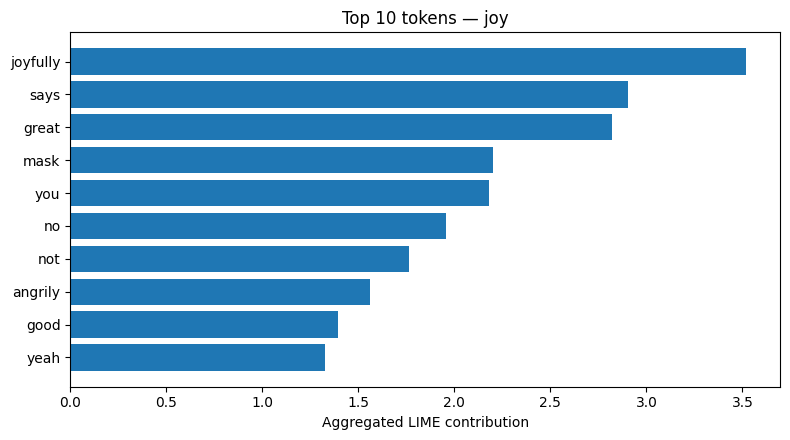

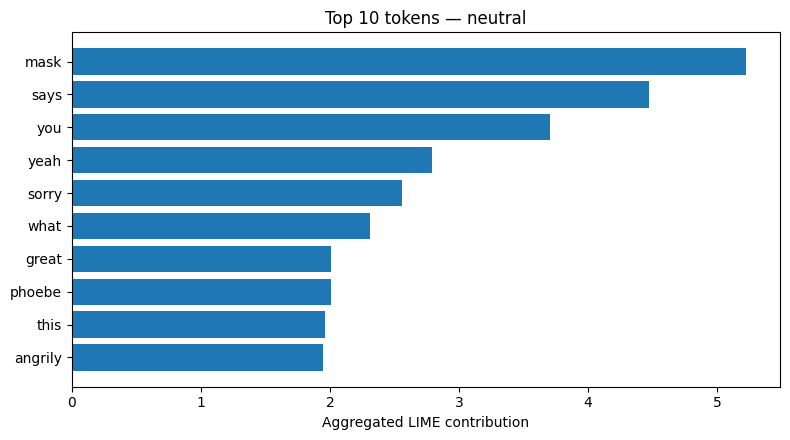

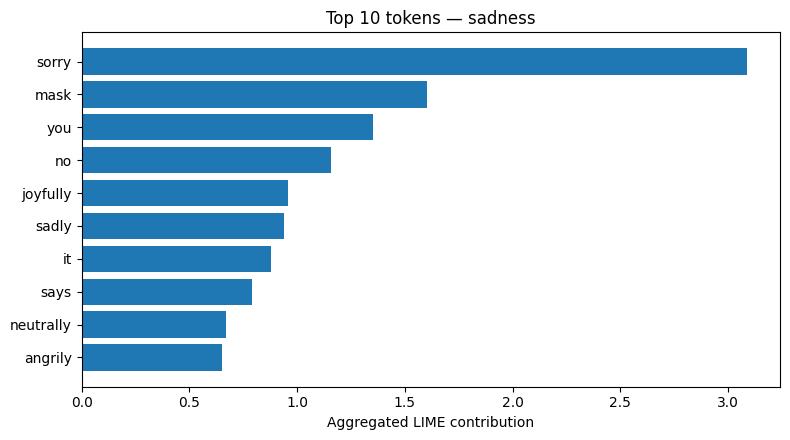

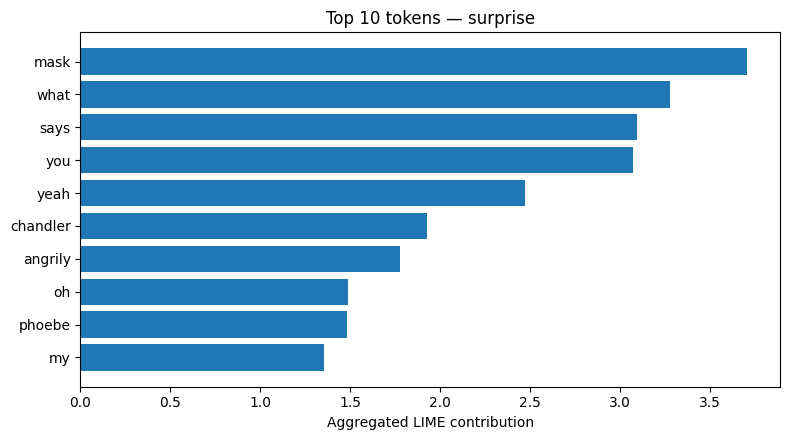

In [ ]:
# Per-emotion Aggregated LIME (Top-10)

!pip -q install tqdm
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os

agg_by_class = {i: defaultdict(float) for i in range(len(CLASS_NAMES))}
SAVE_EVERY = 25

for i, text in enumerate(tqdm(texts, desc="LIME explaining (all emotions)")):
    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=predict_proba,
        num_features=TOP_FEATURES_PER_EXP,
        num_samples=MAX_SAMPLES_PER_UTT,
        top_labels=len(CLASS_NAMES),
    )
    for lab_id in range(len(CLASS_NAMES)):
        for tok, w in exp.as_list(label=lab_id):
            t = norm_token(tok)
            if len(t) >= MIN_TOKEN_LEN:
                agg_by_class[lab_id][t] += (abs(w) if USE_ABS else w)

    if (i + 1) % SAVE_EVERY == 0:
        os.makedirs(os.path.join(BASE_DIR, "explain"), exist_ok=True)
        for lab_id, emo in enumerate(CLASS_NAMES):
            part = pd.DataFrame(
                sorted(agg_by_class[lab_id].items(), key=lambda x: x[1], reverse=True),
                columns=["token", "agg_contribution"]
            )
            part.to_csv(os.path.join(BASE_DIR, "explain", f"lime_partial_{emo}.csv"), index=False)

# Save final CSVs + Top-10 plots
out_dir = os.path.join(BASE_DIR, "explain"); os.makedirs(out_dir, exist_ok=True)
for lab_id, emo in enumerate(CLASS_NAMES):
    df_emo = pd.DataFrame(
        sorted(agg_by_class[lab_id].items(), key=lambda x: x[1], reverse=True),
        columns=["token","agg_contribution"]
    )
    df_emo.to_csv(os.path.join(out_dir, f"lime_aggregated_{emo}.csv"), index=False)

    top = df_emo.head(10)
    plt.figure(figsize=(8, 4.5))
    plt.barh(top["token"][::-1], top["agg_contribution"][::-1])
    plt.xlabel("Aggregated LIME contribution")
    plt.title(f"Top 10 tokens — {emo}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"lime_top10_{emo}.png"), dpi=150)
    plt.show()
    plt.close()


Computing LIME explanations and aggregating weights…


  0%|          | 0/250 [00:00<?, ?it/s]

Aggregation complete.

Saved plot: /content/drive/MyDrive/MELD/explain/lime_top_tokens_sum_grid.png


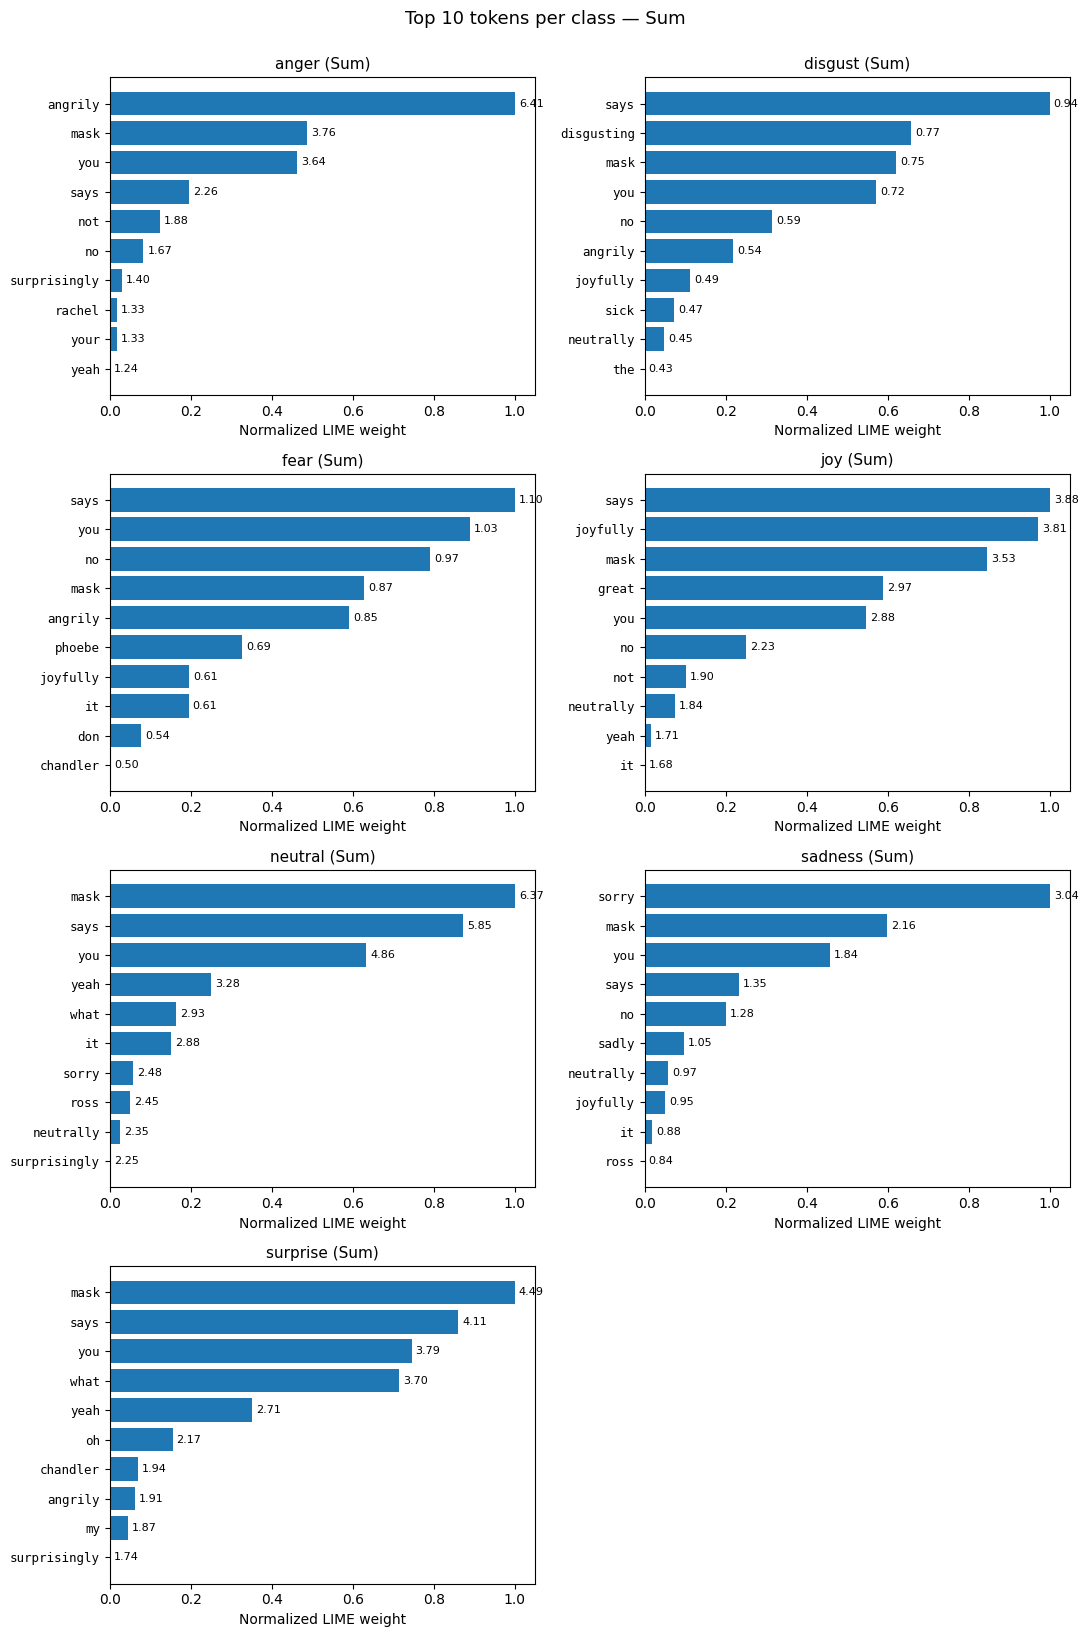

Saved plot: /content/drive/MyDrive/MELD/explain/lime_top_tokens_avg_grid.png


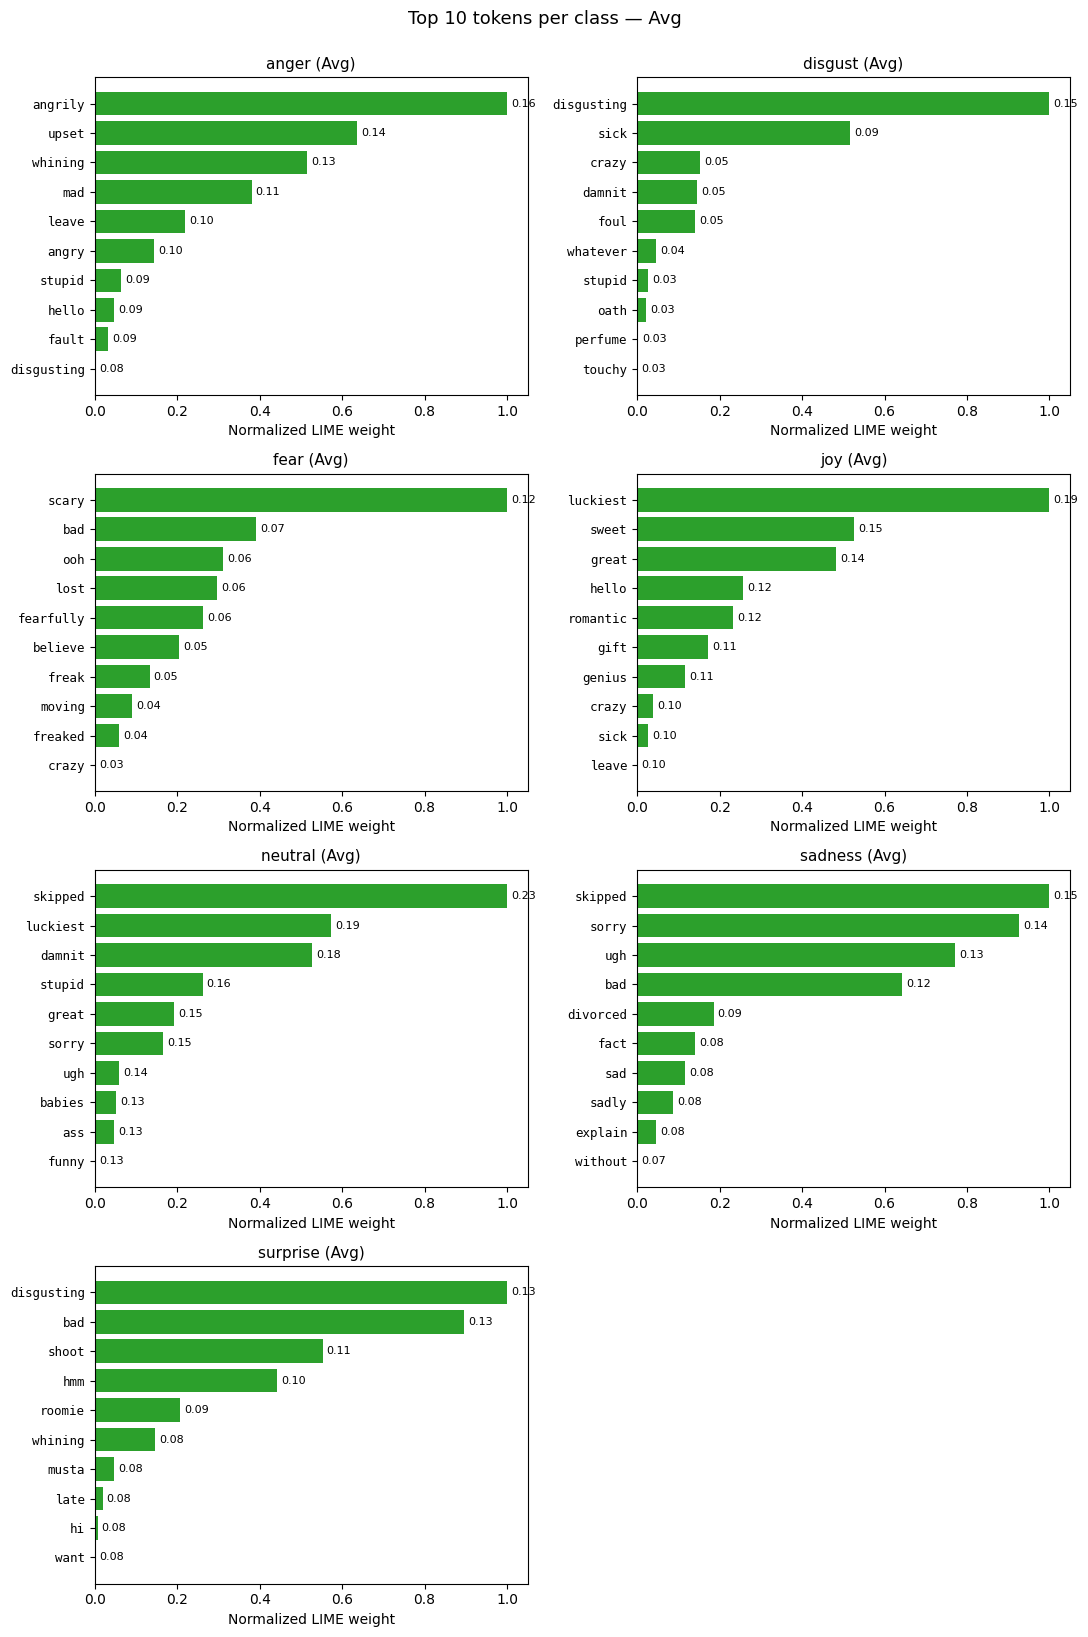

In [ ]:
# Per-class (emotion) Aggregated LIME — Sum vs Average barplots

!pip -q install tqdm
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re

# --- knobs ---
TOP_K = 10
MIN_TOKEN_LEN = 2
EXCLUDE_TOKENS = {"[unused1]", "[unused2]"}  # ignore our FCM markers in charts
USE_ABS = True  # aggregate absolute weights (set False for signed)

# reuse from your earlier cells:
#  - CLASS_NAMES (list of emotions)
#  - predict_proba (text -> probs)
#  - explainer = LimeTextExplainer(...)
#  - texts
num_classes = len(CLASS_NAMES)

# helper: normalize/clean a token emitted by LIME
def norm_token(tok: str) -> str:
    t = tok.strip()
    t = t.lower()               # unify case
    t = re.sub(r"\s+", " ", t)  # collapse whitespace
    return t

# aggregate containers
sum_weights       = {i: defaultdict(float) for i in range(num_classes)}
count_occurrences = {i: defaultdict(int)   for i in range(num_classes)}

print("Computing LIME explanations and aggregating weights…")
for idx, text in enumerate(tqdm(texts, total=len(texts))):
    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=predict_proba,
        num_features=TOP_K * 2,          # grab a few more; we'll take TOP_K later
        num_samples=MAX_SAMPLES_PER_UTT,
        top_labels=num_classes           # all classes at once
    )

    for cls_idx in range(num_classes):
        try:
            pairs = exp.as_list(label=cls_idx)  # [(token, weight), ...]
        except Exception:
            continue
        for token, weight in pairs:
            t = norm_token(token)
            if (t in EXCLUDE_TOKENS) or (len(t) < MIN_TOKEN_LEN):
                continue
            w = abs(weight) if USE_ABS else weight
            sum_weights[cls_idx][t]  += float(w)
            count_occurrences[cls_idx][t] += 1

print("Aggregation complete.\n")

# compute averages
avg_weights = {i: {} for i in range(num_classes)}
for i in range(num_classes):
    for t, s in sum_weights[i].items():
        c = max(1, count_occurrences[i][t])  # safe divide
        avg_weights[i][t] = s / c

# ------- plotting helpers -------
def plot_grid(score_maps, title_suffix, color="tab:blue", save_name=""):
    n_cols = 2
    n_rows = (num_classes + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 4 * n_rows))
    axes = np.array(axes).reshape(-1)  # handle 1-row case

    for cls_idx in range(num_classes):
        ax = axes[cls_idx]
        cls_name = CLASS_NAMES[cls_idx]
        token_scores = score_maps[cls_idx]  # dict token -> score

        if not token_scores:
            ax.set_visible(False)
            continue

        # sort and take top-K
        sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
        tokens, weights = zip(*sorted_tokens)
        arr = np.array(weights, dtype=float)

        # normalize to [0,1] for plotting
        denom = (arr.max() - arr.min())
        norm = (arr - arr.min()) / (denom + 1e-12)

        y = np.arange(len(tokens))
        ax.barh(y, norm, align="center", color=color)
        ax.set_yticks(y)
        ax.set_yticklabels(tokens, fontsize=9, family="monospace")
        ax.invert_yaxis()
        ax.set_title(f"{cls_name} ({title_suffix})", fontsize=11)
        ax.set_xlabel("Normalized LIME weight")

        # annotate with raw score
        for i, w in enumerate(arr):
            ax.text(norm[i] + 0.01, i, f"{w:.2f}", va="center", fontsize=8)

    # hide unused axes
    for j in range(num_classes, n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f"Top {TOP_K} tokens per class — {title_suffix}", y=1.02, fontsize=13)
    if save_name:
        out_dir = os.path.join(BASE_DIR, "explain")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, save_name)
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        print("Saved plot:", out_path)
    plt.show()

# ------- save CSVs and plots -------
out_dir = os.path.join(BASE_DIR, "explain")
os.makedirs(out_dir, exist_ok=True)

# per-class CSVs (sum & average)
for i, emo in enumerate(CLASS_NAMES):
    sum_df = pd.DataFrame(sorted(sum_weights[i].items(), key=lambda x: x[1], reverse=True),
                          columns=["token","sum_lime_weight"])
    avg_df = pd.DataFrame(sorted(avg_weights[i].items(), key=lambda x: x[1], reverse=True),
                          columns=["token","avg_lime_weight"])
    sum_df.to_csv(os.path.join(out_dir, f"lime_sum_{emo}.csv"), index=False)
    avg_df.to_csv(os.path.join(out_dir, f"lime_avg_{emo}.csv"), index=False)

# grid plots
plot_grid(sum_weights, "Sum",  color="tab:blue",  save_name="lime_top_tokens_sum_grid.png")
plot_grid(avg_weights, "Avg",  color="tab:green", save_name="lime_top_tokens_avg_grid.png")



In [ ]:
!pip install shap

In [ ]:
# --- SHAP KernelExplainer for BERT+FCM (drop-in) ---


import numpy as np, matplotlib.pyplot as plt, shap, torch, pandas as pd, os, re

# pick which utterance to explain from your loaded `texts`
INDEX = 9 # change to any index in range(len(texts))
the_text = texts[INDEX]
print(f"Explaining example #{INDEX}:\n", the_text[:200], "...\n")

# 1) Tokenize the selected text to BPE (WITH special tokens so markers stay)
enc_once = tokenizer(the_text, add_special_tokens=True, return_attention_mask=False)
token_ids = enc_once["input_ids"]
tokens    = tokenizer.convert_ids_to_tokens(token_ids)
seq_len   = len(tokens)
print("seq_len:", seq_len)

# 2) Build a masker space over tokens (1=keep token, 0=replace with [MASK])
#    Always keep FCM markers [unused1]/[unused2] and CLS/SEP if present.
protect = set(tokenizer.all_special_tokens) | {"[unused1]", "[unused2]"}
protect_mask = np.array([1 if tok in protect else 0 for tok in tokens], dtype=np.int32)

def mask_and_predict(mask_matrix: np.ndarray) -> np.ndarray:
    """
    mask_matrix: (n_samples, seq_len) with entries {0,1}
    1 -> keep original token, 0 -> replace with [MASK] (except protected tokens).
    Returns softmax probs via your predict_proba (which rebuilds FCM masks).
    """
    texts_ = []
    for row in mask_matrix.astype(int):
        out_toks = []
        for keep, tok in zip(row, tokens):
            if tok in protect:
                out_toks.append(tok)  # keep markers/specials intact
            else:
                out_toks.append(tok if keep == 1 else tokenizer.mask_token)
        texts_.append(tokenizer.convert_tokens_to_string(out_toks))
    return predict_proba(texts_)  # ← uses your existing wrapper that builds FCM masks

# 3) Background samples (include all-ones + a few random masks that respect protect)
num_background = 6
bg = [np.ones(seq_len, dtype=np.int32)]
rng = np.random.default_rng(42)
for _ in range(num_background - 1):
    m = rng.integers(0, 2, size=seq_len, dtype=np.int32)
    m = np.where(protect_mask == 1, 1, m)  # force keep protected tokens
    bg.append(m)
bg = np.stack(bg, axis=0)
print("Background mask shape:", bg.shape)

# 4) Instantiate KernelExplainer
explainer = shap.KernelExplainer(mask_and_predict, bg, link="identity")

# 5) SHAP for a single "all-ones" instance (the actual text)
single = np.ones((1, seq_len), dtype=np.int32)
# choose the class to explain: default = model prediction
with torch.no_grad():
    probs_ = predict_proba([the_text])[0]
pred_idx = int(np.argmax(probs_))
print("Predicted class:", pred_idx)

# nsamples: rule of thumb ~ 40*seq_len (can lower to speed up)
nsamples = min(40 * seq_len, 4000)  # cap for practicality
shap_values = explainer.shap_values(single, nsamples=nsamples)

# 6) Normalize SHAP outputs to shape (num_classes, seq_len)
arr = np.array(shap_values)
if isinstance(shap_values, list):
    shap_vals = np.vstack([sv[0] for sv in shap_values])          # (C, T)
elif arr.ndim == 3 and arr.shape[1] == 1 and arr.shape[2] == seq_len:
    shap_vals = arr[:, 0, :]                                       # (C, T)
elif arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1] == seq_len:
    shap_vals = arr[0].T                                           # (C, T)
elif arr.ndim == 2 and arr.shape[0] == 1 and arr.shape[1] == seq_len:
    shap_vals = arr                                                # (1, T)
else:
    raise ValueError(f"Unexpected SHAP shape: {arr.shape}")

# 7) Prep tokens and SHAP values for the chosen class (exclude special tokens)
cls = pred_idx  # or set any 0..6
tok_list, val_list = [], []
for tok, val in zip(tokens, shap_vals[cls]):
    if tok in tokenizer.all_special_tokens or tok in {"[unused1]", "[unused2]"}:
        continue
    tok_list.append(tok); val_list.append(float(val))

tok_arr = np.array(tok_list)
val_arr = np.array(val_list)

# 8) Take top-K by absolute contribution and plot
TOP_K = 15
order = np.argsort(np.abs(val_arr))[-TOP_K:][::-1]
top_tok = tok_arr[order]
top_val = val_arr[order]

plt.figure(figsize=(8, 5))
colors = ["tab:green" if v > 0 else "tab:red" for v in top_val]
y = np.arange(len(top_tok))
plt.barh(y, top_val, color=colors)
plt.yticks(y, top_tok, fontsize=10, family="monospace")
plt.xlabel("Kernel SHAP value")
plt.title(f"Token contributions — class {cls}")
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()

# save + show
out_dir = os.path.join(BASE_DIR, "explain")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"kernel_shap_tokens_cls{cls}_idx{INDEX}.png")
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


Explaining example #9:
 All says: Hey! Phoebe says: Ohh, you guys, remember that cute client I told you about? I bit him. <s> Rachel <mask> says: Where?! </s> Phoebe neutrally says: On the touchy. Ross neutrally says: And ...

seq_len: 61
Background mask shape: (6, 61)
Predicted class: 6


  0%|          | 0/1 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.72 GiB. GPU 0 has a total capacity of 22.16 GiB of which 649.38 MiB is free. Process 11502 has 21.52 GiB memory in use. Of the allocated memory 19.82 GiB is allocated by PyTorch, and 1.48 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Explaining example: Joey says: Aww, man, now we won’t be bank buddies! Chandler neutrally says: Now, there’s two reasons. <s> Phoebe <mask> says: Hey. </s> All says: Hey! Phoebe says: Ohh, you guys, remember that cute client I told you abou ...
Predicted class index: 4


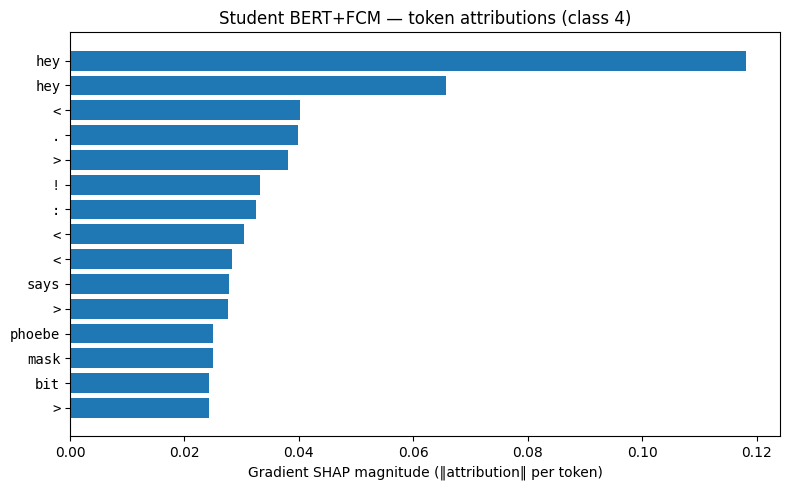

Saved: /content/drive/MyDrive/MELD/explain/gradshap_tokens_cls4_idx6.png


In [ ]:
# --- Gradient SHAP for BERT+FCM (single-input: embeddings only) ---

!pip -q install shap

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, shap, torch

# ===== config =====
CSV_BG   = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")  # background texts file
N_BG     = 20        # how many background utterances
MAX_LEN  = 256       # must match your tokenizer setting when training
INDEX    = 6       # which sample from `texts` to explain (or set TARGET_TEXT manually)
TOP_K    = 15        # top tokens to plot

# pick a target text
try:
    TARGET_TEXT = texts[INDEX]
except NameError:
    df_tmp = pd.read_csv(CSV_BG)
    assert "student_input" in df_tmp.columns, "Need 'student_input' in CSV_BG."
    TARGET_TEXT = df_tmp["student_input"].iloc[INDEX]

print("Explaining example:", TARGET_TEXT[:220], "...")

# ===== helper: build FCM masks from [unused1]/[unused2] =====
Q_OPEN, Q_CLOSE = "[unused1]", "[unused2]"
ID_OPEN  = tokenizer.convert_tokens_to_ids(Q_OPEN)
ID_CLOSE = tokenizer.convert_tokens_to_ids(Q_CLOSE)

def batch_masks_from_markers(input_ids, attention_mask):
    pm_list, qm_list, fm_list = [], [], []
    for ids, am in zip(input_ids.tolist(), attention_mask.tolist()):
        T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
        s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
        e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
        if s is None or e is None or e <= s:
            for i in range(T):
                if am[i]==1: qm[i]=1
        else:
            for i in range(0, s):
                if am[i]==1: pm[i]=1
            for i in range(s+1, e):
                if am[i]==1: qm[i]=1
            for i in range(e+1, T):
                if am[i]==1: fm[i]=1
        pm_list.append(pm); qm_list.append(qm); fm_list.append(fm)
    return (torch.tensor(pm_list, device=device),
            torch.tensor(qm_list, device=device),
            torch.tensor(fm_list, device=device))

# ===== wrapper: stores fixed masks; SHAP input = embeddings only =====
class FCMEmbWrapperFixedMasks(torch.nn.Module):
    def __init__(self, student_model):
        super().__init__()
        self.bert = student_model.bert      # backbone
        self.head = student_model.head      # FCM head
        # placeholders for fixed masks (set via set_masks)
        self.attn = None
        self.pm   = None
        self.qm   = None
        self.fm   = None

    def set_masks(self, attention_mask, past_mask, query_mask, future_mask):
        # register as buffers so they move with .to(device) but require_grad=False
        self.attn = attention_mask
        self.pm   = past_mask
        self.qm   = query_mask
        self.fm   = future_mask

    def mean_pool(self, L, mask_bool):
        lens = mask_bool.sum(dim=1).clamp(min=1).unsqueeze(-1)
        return (L * mask_bool.unsqueeze(-1)).sum(dim=1) / lens

    def forward(self, inputs_embeds):
        out = self.bert(inputs_embeds=inputs_embeds,
                        attention_mask=self.attn,
                        return_dict=True)
        L  = out.last_hidden_state
        Fp = self.mean_pool(L, self.pm.bool())
        Fq = self.mean_pool(L, self.qm.bool())
        Ff = self.mean_pool(L, self.fm.bool())
        logits = self.head(Fp, Fq, Ff)
        return logits

wrapped = FCMEmbWrapperFixedMasks(model).to(device).eval()

# ===== tokenize the example EXACTLY ONCE to define length =====
enc_ex = tokenizer(
    TARGET_TEXT,
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)
enc_ex = {k: v.to(device) for k, v in enc_ex.items()}
pm_ex, qm_ex, fm_ex = batch_masks_from_markers(enc_ex["input_ids"], enc_ex["attention_mask"])

# set the fixed masks inside wrapper (batch=1)
wrapped.set_masks(enc_ex["attention_mask"], pm_ex, qm_ex, fm_ex)

# build example embeddings WITH gradients
emb_layer = model.bert.embeddings.word_embeddings
emb_ex = emb_layer(enc_ex["input_ids"])   # [1, T, H]
emb_ex.requires_grad_(True)               # <-- important for Gradient SHAP
T_ex = emb_ex.shape[1]

# ===== build BACKGROUND with the same T_ex, but embeddings don't need gradients =====
if 'texts' in globals() and len(texts) >= N_BG:
    bg_texts = texts[:N_BG]
else:
    bg_df = pd.read_csv(CSV_BG)
    bg_texts = bg_df["student_input"].sample(min(N_BG, len(bg_df)), random_state=0).tolist()

enc_bg = tokenizer(
    bg_texts,
    padding="max_length",
    truncation=True,
    max_length=T_ex,             # force same length as example
    return_tensors="pt"
)
enc_bg = {k: v.to(device) for k, v in enc_bg.items()}
# Use the SAME masks as the example (standard for Gradient SHAP baselines)
# If you prefer, you can recompute masks per bg sample, but keeping them fixed is acceptable.
pm_bg, qm_bg, fm_bg = pm_ex.expand(enc_bg["input_ids"].size(0), -1), \
                      qm_ex.expand(enc_bg["input_ids"].size(0), -1), \
                      fm_ex.expand(enc_bg["input_ids"].size(0), -1)

with torch.no_grad():
    emb_bg = emb_layer(enc_bg["input_ids"])  # [B, T_ex, H]
# lock masks into the wrapper for background shape (batch dim won't be used directly by SHAP)
# (the wrapper uses masks from the current .set_masks(), which we set for the example already)

# ===== instantiate GradientExplainer with BACKGROUND = [emb_bg] (single input) =====
explainer = shap.GradientExplainer(wrapped, emb_bg)

# ===== predicted class for title =====
with torch.no_grad():
    logits = wrapped(emb_ex)                  # [1, C]
    probs  = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()
pred_idx = int(np.argmax(probs))
print("Predicted class index:", pred_idx)

# ===== compute SHAP values (single input) =====
# result is typically a list per class with shape [1, T, H]
raw_shap = explainer.shap_values(emb_ex)

# normalize to (C, T, H)
arr = np.array(raw_shap)
if isinstance(raw_shap, list):
    class_maps = [sv[0] for sv in raw_shap]       # each (T, H)
    shap_cth = np.stack(class_maps, axis=0)       # (C, T, H)
elif arr.ndim == 4 and arr.shape[0] == 1:
    # (1, T, H, C) or (1, C, T, H)
    if arr.shape[-1] == logits.shape[-1]:
        shap_cth = np.transpose(arr[0], (2, 0, 1))  # (C, T, H)
    elif arr.shape[1] == logits.shape[-1]:
        shap_cth = arr[0]                            # (C, T, H)
    else:
        raise ValueError(f"Unexpected SHAP shape: {arr.shape}")
elif arr.ndim == 3 and arr.shape[0] == logits.shape[-1]:
    shap_cth = arr                                   # (C, T, H)
else:
    raise ValueError(f"Unhandled SHAP shape: {arr.shape}")

# reduce hidden dim -> per-token magnitude for predicted class
token_attr = np.linalg.norm(shap_cth[pred_idx], axis=-1)   # (T,)

# prepare tokens and mask out specials / FCM markers
tokens_bpe = tokenizer.convert_ids_to_tokens(enc_ex["input_ids"][0].detach().cpu().numpy())
keep = [t not in tokenizer.all_special_tokens and t not in {"[unused1]","[unused2]"} for t in tokens_bpe]
tokens_f = np.array([t for t, k in zip(tokens_bpe, keep) if k])
attrs_f  = np.array([a for a, k in zip(token_attr, keep) if k])

# top-K
k = min(TOP_K, len(tokens_f))
order = np.argsort(attrs_f)[-k:][::-1]
top_tok = tokens_f[order]
top_val = attrs_f[order]

# plot
plt.figure(figsize=(8, 5))
y = np.arange(len(top_tok))
plt.barh(y, top_val, color='tab:blue', align='center')
plt.yticks(y, top_tok, fontsize=10, family='monospace')
plt.xlabel("Gradient SHAP magnitude (‖attribution‖ per token)")
plt.title(f"Student BERT+FCM — token attributions (class {pred_idx})")
plt.gca().invert_yaxis()
plt.tight_layout()
out_dir = os.path.join(BASE_DIR, "explain"); os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"gradshap_tokens_cls{pred_idx}_idx{INDEX}.png")
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", out_path)



In [ ]:
# --- Gradient SHAP aggregation for Student BERT+FCM (fixed masks from background) ---

!pip -q install shap

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap, torch
from collections import defaultdict

# ===== knobs =====
CSV_SPLIT        = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")  # or train_for_student_paragraph.csv
NUM_TO_EXPLAIN   = 100      # how many utterances to aggregate over
BACKGROUND_SIZE  = 20       # background samples for SHAP
MAX_LEN          = 256      # must match your student setup
TARGET_EMOTION   = "surprise"  # pick emotion to aggregate (or set to None to use predicted per-sample)
TOP_K            = 20
EMOTIONS         = ["anger","disgust","fear","joy","neutral","sadness","surprise"]
EMO2ID           = {e:i for i,e in enumerate(EMOTIONS)}

# --- normalize markers in student text for BERT (if needed) ---
def normalize_markers(s: str) -> str:
    s = re.sub(r"\s*</s>\s*", " [unused2] ", s)
    s = re.sub(r"\s*<s>\s*",  " [unused1] ", s)
    return s

# --- load split ---
df_split = pd.read_csv(CSV_SPLIT)
assert "student_input" in df_split.columns, "Need 'student_input' in CSV."
texts_all = df_split["student_input"].astype(str).tolist()
N = min(NUM_TO_EXPLAIN, len(texts_all))
texts = [normalize_markers(t) for t in texts_all[:N]]

# ===== FCM masks from markers =====
ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def batch_masks_from_markers(input_ids, attention_mask):
    pm_list, qm_list, fm_list = [], [], []
    for ids, am in zip(input_ids.tolist(), attention_mask.tolist()):
        T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
        s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
        e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
        if s is None or e is None or e <= s:
            for i in range(T):
                if am[i]==1: qm[i]=1
        else:
            for i in range(0, s):
                if am[i]==1: pm[i]=1
            for i in range(s+1, e):
                if am[i]==1: qm[i]=1
            for i in range(e+1, T):
                if am[i]==1: fm[i]=1
        pm_list.append(pm); qm_list.append(qm); fm_list.append(fm)
    return (torch.tensor(pm_list, device=device),
            torch.tensor(qm_list, device=device),
            torch.tensor(fm_list, device=device))

class FCMEmbWrapperFixedMasks(torch.nn.Module):
    def __init__(self, student_model):
        super().__init__()
        self.bert = student_model.bert
        self.head = student_model.head
        self.attn = None; self.pm = None; self.qm = None; self.fm = None

    def set_masks(self, attention_mask, past_mask, query_mask, future_mask):
        # store masks as buffers (no grad)
        self.attn = attention_mask
        self.pm   = past_mask
        self.qm   = query_mask
        self.fm   = future_mask

    @staticmethod
    def mean_pool(L, mask_bool):
        lens = mask_bool.sum(dim=1).clamp(min=1).unsqueeze(-1)
        return (L * mask_bool.unsqueeze(-1)).sum(dim=1) / lens

    def _match_batch(self, B: int):
        """
        Ensure masks have batch dimension == B.
        If stored masks are [B_bg, T] and B!=B_bg (e.g., B==1), slice the first row and expand.
        """
        def fit(m):
            if m.size(0) == B:
                return m
            # use the first mask and expand across batch
            return m[:1].expand(B, -1)
        attn = fit(self.attn)
        pm   = fit(self.pm)
        qm   = fit(self.qm)
        fm   = fit(self.fm)
        return attn, pm, qm, fm

    def forward(self, inputs_embeds):
        B, T, H = inputs_embeds.size()
        attn, pm, qm, fm = self._match_batch(B)

        out = self.bert(inputs_embeds=inputs_embeds,
                        attention_mask=attn,
                        return_dict=True)
        L  = out.last_hidden_state
        Fp = self.mean_pool(L, pm.bool())
        Fq = self.mean_pool(L, qm.bool())
        Ff = self.mean_pool(L, fm.bool())
        return self.head(Fp, Fq, Ff)   # logits [B, C]


wrapped = FCMEmbWrapperFixedMasks(model).to(device).eval()
emb_layer = model.bert.embeddings.word_embeddings

# ===== build BACKGROUND (embeddings + masks) and set masks BEFORE making explainer =====
bg_src = texts_all[N : N + 5*BACKGROUND_SIZE] or texts_all[:5*BACKGROUND_SIZE]
bg_texts = [normalize_markers(t) for t in bg_src[:BACKGROUND_SIZE]]

enc_bg = tokenizer(bg_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
enc_bg = {k: v.to(device) for k,v in enc_bg.items()}
with torch.no_grad():
    emb_bg = emb_layer(enc_bg["input_ids"])   # [B_bg, MAX_LEN, H]

# compute masks for the background batch and SET THEM on the wrapper
pm_bg, qm_bg, fm_bg = batch_masks_from_markers(enc_bg["input_ids"], enc_bg["attention_mask"])
wrapped.set_masks(enc_bg["attention_mask"], pm_bg, qm_bg, fm_bg)

# create SHAP explainer AFTER masks are set so forward() has valid masks
explainer = shap.GradientExplainer(wrapped, emb_bg)

# ===== aggregation buckets =====
token_scores = defaultdict(list)  # token -> list of scores

# ===== loop over utterances =====
for i, raw_text in enumerate(texts):
    # tokenize example to fixed MAX_LEN (embeddings only; masks remain the BACKGROUND ones)
    enc = tokenizer(raw_text, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    enc = {k: v.to(device) for k,v in enc.items()}
    emb_ex = emb_layer(enc["input_ids"])     # [1, MAX_LEN, H]
    emb_ex.requires_grad_(True)

    # choose class to explain
    with torch.no_grad():
        probs = torch.softmax(wrapped(emb_ex), dim=-1)[0].detach().cpu().numpy()
    if TARGET_EMOTION is None:
        target_idx = int(np.argmax(probs))
    else:
        if TARGET_EMOTION not in EMO2ID:
            raise ValueError(f"Unknown emotion '{TARGET_EMOTION}'. Choose from {EMOTIONS}.")
        target_idx = EMO2ID[TARGET_EMOTION]

    # SHAP values (single input; masks fixed to background)
    raw = explainer.shap_values(emb_ex)
    arr = np.array(raw)
    if isinstance(raw, list):
        class_maps = [sv[0] for sv in raw]              # each (T,H)
        shap_cth = np.stack(class_maps, axis=0)         # (C,T,H)
    elif arr.ndim == 4 and arr.shape[0] == 1:
        if arr.shape[-1] == len(EMOTIONS):
            shap_cth = np.transpose(arr[0], (2,0,1))    # (C,T,H)
        elif arr.shape[1] == len(EMOTIONS):
            shap_cth = arr[0]                           # (C,T,H)
        else:
            raise ValueError(f"Unexpected SHAP shape: {arr.shape}")
    elif arr.ndim == 3 and arr.shape[0] == len(EMOTIONS):
        shap_cth = arr                                  # (C,T,H)
    else:
        raise ValueError(f"Unhandled SHAP shape: {arr.shape}")

    # per-token magnitude for target class
    token_attr = np.linalg.norm(shap_cth[target_idx], axis=-1)   # (T,)

    # ids -> tokens; filter specials & markers
    ids = enc["input_ids"][0].detach().cpu().numpy().tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    for tok, score in zip(toks, token_attr):
        if tok in tokenizer.all_special_tokens or tok in {"[unused1]","[unused2]"}:
            continue
        clean = tok.replace("##", "")
        if clean:
            token_scores[clean.lower()].append(float(score))

    if (i+1) % 20 == 0:
        print(f"  processed {i+1}/{N}")

print("Aggregation done.")

# ===== compute mean per token and plot Top-K =====
mean_scores = {tok: (np.mean(vals) if len(vals) else 0.0) for tok, vals in token_scores.items()}
top = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_K]

print(f"\nTop {TOP_K} tokens for emotion = {TARGET_EMOTION or 'predicted'} (mean Gradient SHAP over {N} utts):")
for t, s in top:
    print(f"  {t:15s}  {s:.4f}")

# plot + save
out_dir = os.path.join(BASE_DIR, "explain"); os.makedirs(out_dir, exist_ok=True)
plt.figure(figsize=(10, 6))
labels = [t for t,_ in top][::-1]
vals   = [s for _,s in top][::-1]
plt.barh(range(len(labels)), vals)
plt.yticks(range(len(labels)), labels, fontsize=10, family="monospace")
plt.xlabel("Mean Gradient SHAP magnitude")
title_em = TARGET_EMOTION or "predicted"
plt.title(f"Top {TOP_K} tokens — {title_em} (N={N})")
plt.tight_layout()
png_path = os.path.join(out_dir, f"gradshap_mean_top{TOP_K}_{title_em}_N{N}.png")
plt.savefig(png_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved plot:", png_path)


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 21.38 MiB is free. Process 11502 has 22.13 GiB memory in use. Of the allocated memory 20.98 GiB is allocated by PyTorch, and 951.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 146.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.8 MB/s eta 0:00:00


In [ ]:
import os, torch, torch.nn as nn
from transformers import AutoTokenizer, AutoModel

CKPT_DIR   = "/content/drive/MyDrive/MELD/student_bert_fcm/student_bert_fcm"  # <- your saved folder
MODEL_NAME = "bert-base-uncased"   # the base you trained with
NUM_LABELS = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- model definition (same shape as when you trained) -----
def mean_pool(L, mask_bool):
    lens = mask_bool.sum(dim=1).clamp(min=1).unsqueeze(-1)
    return (L * mask_bool.unsqueeze(-1)).sum(dim=1) / lens

class FineGrainedHead(nn.Module):
    def __init__(self, hidden, proj=None, num_labels=NUM_LABELS, pdrop=0.1):
        super().__init__()
        if proj is None: proj = hidden
        self.proj = nn.Linear(3*hidden, proj)  # 3H -> H
        self.tanh = nn.Tanh()
        self.drop = nn.Dropout(pdrop)
        self.out  = nn.Linear(proj, num_labels)
    def forward(self, Fp, Fq, Ff):
        Z = torch.cat([Fp, Fq, Ff], dim=-1)
        H = self.drop(self.tanh(self.proj(Z)))
        return self.out(H)

class BERTWithFCM(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=NUM_LABELS):
        super().__init__()
        self.bert   = AutoModel.from_pretrained(model_name)
        self.hidden = self.bert.config.hidden_size
        self.head   = FineGrainedHead(
            hidden=self.hidden, proj=self.hidden,
            num_labels=num_labels, pdrop=self.bert.config.hidden_dropout_prob
        )
    def forward(self, input_ids=None, attention_mask=None,
                past_mask=None, query_mask=None, future_mask=None):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        L   = out.last_hidden_state
        Fp  = mean_pool(L, past_mask.bool())
        Fq  = mean_pool(L, query_mask.bool())
        Ff  = mean_pool(L, future_mask.bool())
        return self.head(Fp, Fq, Ff)

# ----- load weights -----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = BERTWithFCM(model_name=MODEL_NAME, num_labels=NUM_LABELS)

bin_path  = os.path.join(CKPT_DIR, "pytorch_model.bin")
safe_path = os.path.join(CKPT_DIR, "model.safetensors")

if os.path.exists(bin_path):
    state = torch.load(bin_path, map_location="cpu")
elif os.path.exists(safe_path):
    from safetensors.torch import load_file
    state = load_file(safe_path)
else:
    raise FileNotFoundError(f"No model weights found in {CKPT_DIR}")

missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded student weights.\nMissing:", missing, "\nUnexpected:", unexpected)

model.to(device).eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loaded student weights.
Missing: [] 
Unexpected: []


BERTWithFCM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
# === BertViz for student BERT+FCM (fixed) ===
!pip -q install bertviz
from google.colab import output
output.enable_custom_widget_manager()  # enable interactive HTML in Colab

import os, re, torch, pandas as pd
from bertviz import head_view, model_view
from transformers import AutoModel
BASE_DIR   = "/content/drive/MyDrive/MELD"
# --------- 0) Make backbone "eager" to silence SDPA warning (keep your fine-tuned weights) ----------
with torch.no_grad():
    base_name = getattr(model.bert, "name_or_path", "bert-base-uncased")
    eager_bert = AutoModel.from_pretrained(base_name, attn_implementation="eager")
    eager_bert.load_state_dict(model.bert.state_dict(), strict=True)
model.bert = eager_bert.to(next(model.parameters()).device).eval()

# --------- helpers ----------
def normalize_markers(s: str) -> str:
    """Convert <s> … </s> to the BERT markers your pipeline uses for FCM."""
    s = re.sub(r"\s*</s>\s*", " [unused2] ", s)
    s = re.sub(r"\s*<s>\s*",  " [unused1] ", s)
    return s

def get_backbone_attentions(student_model, tokenizer, text, max_len=256):
    text_norm = normalize_markers(str(text))
    enc = tokenizer(
        text_norm,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_len
    )
    device = next(student_model.parameters()).device
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = student_model.bert(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            output_attentions=True,
            return_dict=True
        )
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist())
    return out.attentions, tokens, text_norm

def find_query_span(tokens, open_tok="[unused1]", close_tok="[unused2]"):
    try:
        a = tokens.index(open_tok)
        b = tokens.index(close_tok)
        if b > a:
            return a, b
    except ValueError:
        pass
    return -1, -1

def bertviz_student(student_model, tokenizer, sample_text, max_len=256):
    attentions, tokens, _ = get_backbone_attentions(student_model, tokenizer, sample_text, max_len=max_len)
    a, b = find_query_span(tokens)

    # quick orientation print
    print("Text:", sample_text)
    print("Tokens (QUERY boundaries bracketed if found):")
    preview = []
    for i, t in enumerate(tokens):
        if i == a or i == b:
            preview.append(f"[{t}]")
        else:
            preview.append(t)
        if len(preview) >= 160:
            break
    print(" ".join(preview))
    if a != -1 and b != -1:
        print(f"(QUERY span is between positions {a} and {b})")

    print("\n— Head View —")
    head_view(attentions, tokens, html_action='view')  # no 'title' arg on older bertviz

    print("\n— Model View —")
    model_view(attentions, tokens, html_action='view')  # no 'title' arg

# --------- 1) Choose an utterance directly from your CSV and visualize ----------
CSV_PATH = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")  # or "train_for_student_paragraph.csv"
INDEX    = 0     # change to any row index
MAX_LEN  = 256   # keep consistent with your student

df = pd.read_csv(CSV_PATH)

if "student_input" in df.columns:
    sample_text = df.loc[INDEX, "student_input"]
elif "Utterance" in df.columns:
    spk = df.loc[INDEX, "Speaker"] if "Speaker" in df.columns else "Speaker"
    utt = df.loc[INDEX, "Utterance"]
    sample_text = f"<s> {spk} <mask> says: {utt} </s>"
else:
    # last resort: first non-empty cell text
    row = df.iloc[INDEX].astype(str).tolist()
    sample_text = next((c for c in row if isinstance(c, str) and c.strip()), "Hello.")

bertviz_student(model, tokenizer, sample_text, max_len=MAX_LEN)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 144.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.7 MB/s eta 0:00:00
Text: <s> Phoebe <mask> says: Oh my God, he’s lost it. He’s totally lost it. </s> Monica says: What?
Tokens (QUERY boundaries bracketed if found):
[CLS] [ unused ##1 ] phoebe < mask > says : oh my god , he ’ s lost it . he ’ s totally lost it . [ unused ##2 ] monica says : what ? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Buffered data was truncated after reaching the output size limit.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 127.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Loaded student weights.
Missing: [] 
Unexpected: []
Top tokens per emotion by average saliency:
     emotion

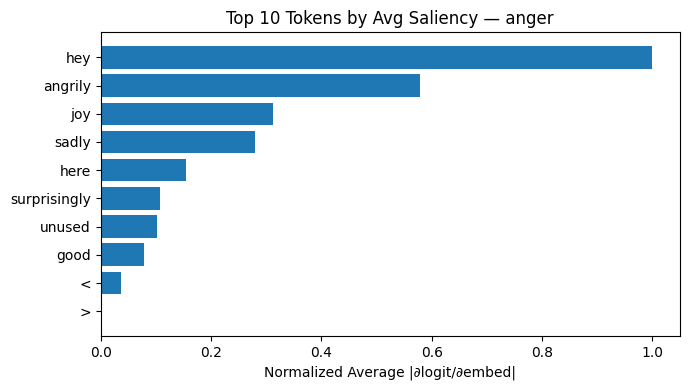

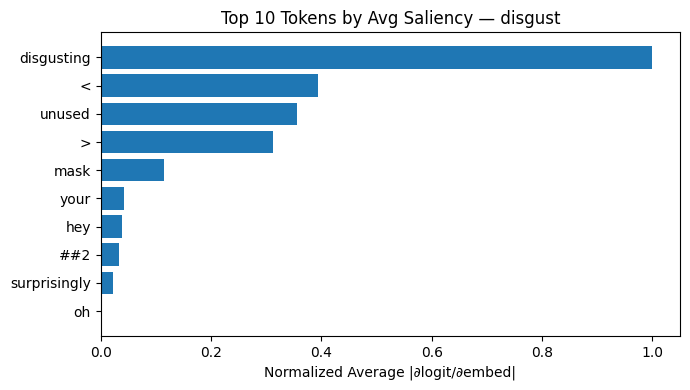

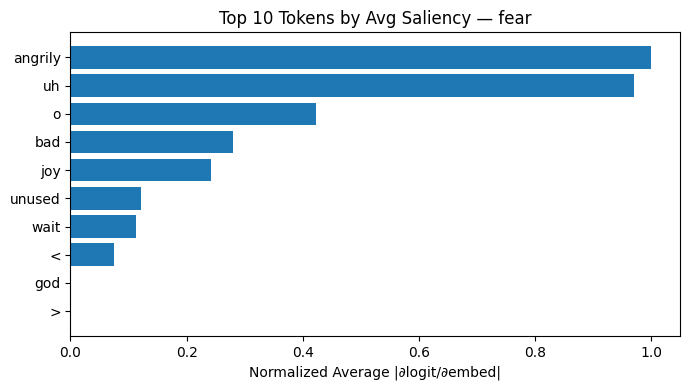

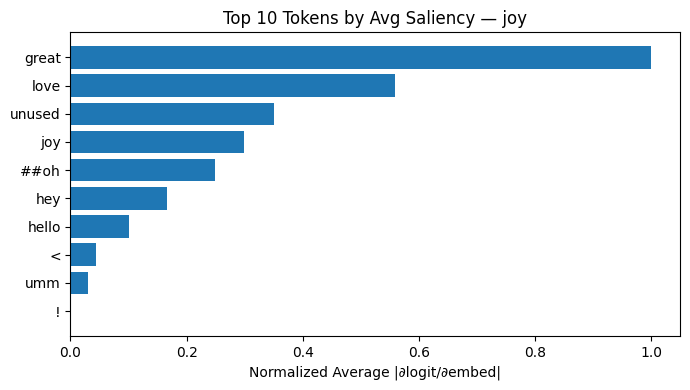

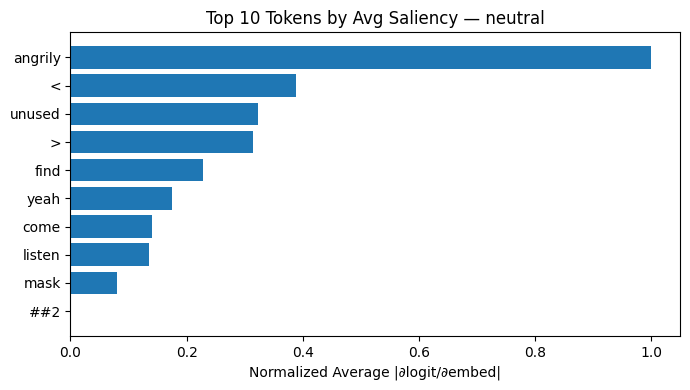

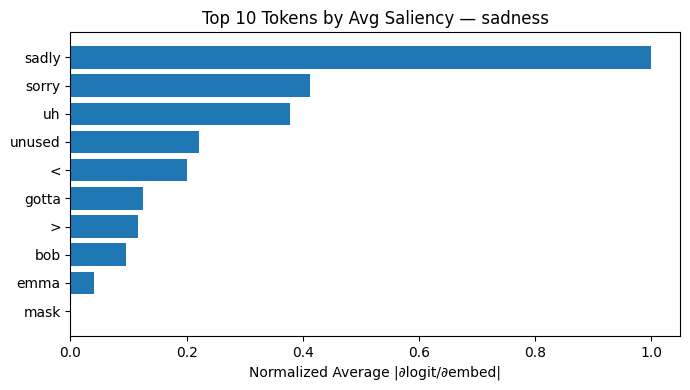

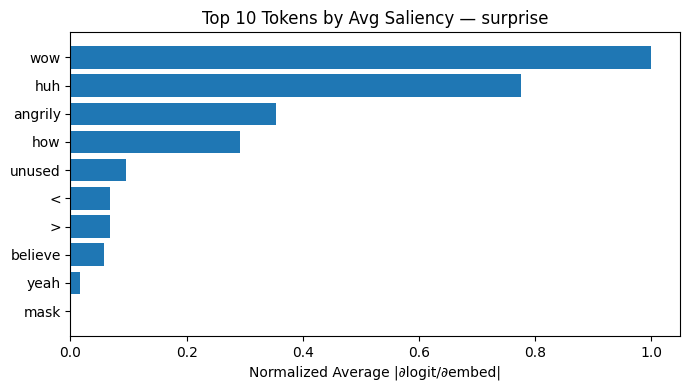

In [ ]:
# ===== Global Captum Saliency for Student BERT+FCM (per-emotion top tokens, markers filtered) =====
!pip -q install captum

import os, re
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from captum.attr import Saliency

# ------------------- config / paths -------------------
BASE_DIR   = "/content/drive/MyDrive/MELD"  # <-- change if needed
CKPT_DIR   = os.path.join(BASE_DIR, "student_bert_fcm/student_bert_fcm")
MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 7
EMOTIONS   = ["anger","disgust","fear","joy","neutral","sadness","surprise"]
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose the CSV you want to explain:
# - Suggestive student text: "dev_for_student_paragraph.csv" or "train_for_student_paragraph.csv"
# - Raw MELD: a CSV with "Utterance" + "Emotion"
CSV_PATH   = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")

# Global aggregation params
N_PER_EMO  = 50    # sample size per emotion
TOP_K      = 10    # top tokens to show per emotion
MAX_LEN    = 256

# ------------------- model definition (BERT + FCM head) -------------------
def mean_pool(L, mask_bool):
    lens = mask_bool.sum(dim=1).clamp(min=1).unsqueeze(-1)
    return (L * mask_bool.unsqueeze(-1)).sum(dim=1) / lens

class FineGrainedHead(nn.Module):
    def __init__(self, hidden, proj=None, num_labels=NUM_LABELS, pdrop=0.1):
        super().__init__()
        if proj is None: proj = hidden
        self.proj = nn.Linear(3*hidden, proj)   # 3H -> H
        self.tanh = nn.Tanh()
        self.drop = nn.Dropout(pdrop)
        self.out  = nn.Linear(proj, num_labels) # H -> C
    def forward(self, Fp, Fq, Ff):
        Z = torch.cat([Fp, Fq, Ff], dim=-1)
        H = self.drop(self.tanh(self.proj(Z)))
        return self.out(H)

class BERTWithFCM(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=NUM_LABELS):
        super().__init__()
        self.bert   = AutoModel.from_pretrained(model_name)
        self.hidden = self.bert.config.hidden_size
        self.head   = FineGrainedHead(
            hidden=self.hidden, proj=self.hidden,
            num_labels=num_labels, pdrop=self.bert.config.hidden_dropout_prob
        )
    def forward(self, input_ids=None, attention_mask=None,
                past_mask=None, query_mask=None, future_mask=None,
                inputs_embeds=None, **kwargs):  # ignore extra kwargs (e.g., token_type_ids)
        out = self.bert(
            input_ids=input_ids if inputs_embeds is None else None,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            return_dict=True
        )
        L   = out.last_hidden_state
        Fp  = mean_pool(L, past_mask.bool())
        Fq  = mean_pool(L, query_mask.bool())
        Ff  = mean_pool(L, future_mask.bool())
        return self.head(Fp, Fq, Ff)

# ------------------- load tokenizer + weights -------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = BERTWithFCM(model_name=MODEL_NAME, num_labels=NUM_LABELS)

bin_path  = os.path.join(CKPT_DIR, "pytorch_model.bin")
safe_path = os.path.join(CKPT_DIR, "model.safetensors")
if os.path.exists(bin_path):
    state = torch.load(bin_path, map_location="cpu")
elif os.path.exists(safe_path):
    from safetensors.torch import load_file
    state = load_file(safe_path)
else:
    raise FileNotFoundError(f"No model weights found in {CKPT_DIR}")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded student weights.\nMissing:", missing, "\nUnexpected:", unexpected)

model.to(device).eval()

# ------------------- FCM markers & masks -------------------
def normalize_markers(text: str) -> str:
    # convert <s> … </s> to the single BERT tokens for the QUERY span
    text = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    text = re.sub(r"\s*<s>\s*",  " [unused1] ", text)
    return text

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=device),
        torch.tensor([qm], device=device),
        torch.tensor([fm], device=device)
    )

# ------------------- token filtering (drop markers & specials) -------------------
SPECIAL_DROP = {"[unused1]", "[unused2]"}
SPECIAL_DROP |= set(tokenizer.all_special_tokens)  # adds [CLS], [SEP], [PAD], [MASK], etc.

def filter_tokens(tokens, scores):
    keep = [i for i, t in enumerate(tokens) if t not in SPECIAL_DROP]
    return [tokens[i] for i in keep], np.asarray(scores)[keep]

# ------------------- saliency for text (predicted class) -------------------
def saliency_for_text(text, target_label=None, max_len=MAX_LEN):
    text = normalize_markers(text)
    enc = tokenizer(text, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=max_len).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"])

    emb_layer = model.bert.embeddings.word_embeddings
    embeds = emb_layer(enc["input_ids"]).clone().detach().requires_grad_(True)  # [1,T,H]

    def forward_fn(inputs_embeds):
        logits = model(inputs_embeds=inputs_embeds,
                       attention_mask=enc["attention_mask"],
                       past_mask=pm, query_mask=qm, future_mask=fm)
        if target_label is None:
            return logits.max(dim=1)[0]
        return logits[:, target_label]

    sal = Saliency(forward_fn)
    attributions = sal.attribute(embeds)  # [1,T,H]
    token_scores = attributions.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    # DROP markers and specials here ⬇
    tokens, token_scores = filter_tokens(tokens, token_scores)
    return tokens, token_scores

@torch.no_grad()
def predict_label(text, max_len=MAX_LEN):
    text = normalize_markers(text)
    enc = tokenizer(text, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=max_len).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"])
    logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
    return int(torch.softmax(logits, dim=-1)[0].argmax().item())

def minmax_norm(arr):
    arr = np.asarray(arr, dtype=float)
    rng = np.ptp(arr)
    if rng == 0:
        return np.zeros_like(arr)
    return (arr - arr.min()) / rng

# ------------------- load data -------------------
df = pd.read_csv(CSV_PATH)
TEXT_COL = "student_input" if "student_input" in df.columns else "Utterance"
if TEXT_COL not in df.columns:
    raise ValueError(f"No text column found in {CSV_PATH}. Need 'student_input' or 'Utterance'.")
LABEL_COL = "Emotion" if "Emotion" in df.columns else None
use_emotions = df[LABEL_COL].unique().tolist() if LABEL_COL else EMOTIONS

# ------------------- GLOBAL AGGREGATION -------------------
emotion_token_scores = {e: defaultdict(list) for e in use_emotions}

for emo in use_emotions:
    if LABEL_COL:
        subset = df[df[LABEL_COL] == emo]
        if subset.empty:
            continue
        texts = subset[TEXT_COL].sample(min(len(subset), N_PER_EMO), random_state=42).tolist()
    else:
        texts = df[TEXT_COL].sample(min(len(df), N_PER_EMO), random_state=42).tolist()

    for t in texts:
        cls_idx = predict_label(t)              # explain predicted class
        toks, scs = saliency_for_text(t, target_label=cls_idx)
        for tk, sc in zip(toks, scs):
            emotion_token_scores[emo][tk].append(sc)

# Build DataFrame of average saliency per token/emotion and take top-K
rows = []
for emo, tok_dict in emotion_token_scores.items():
    for tk, vals in tok_dict.items():
        if len(vals) >= 5:  # skip very rare tokens
            rows.append({"emotion": emo, "token": tk, "count": len(vals), "avg_saliency": float(np.mean(vals))})
df_all = pd.DataFrame(rows)

if df_all.empty:
    print("No aggregated saliency computed (check data/labels).")
else:
    df_top = (
        df_all.sort_values(["emotion", "avg_saliency"], ascending=[True, False])
              .groupby("emotion")
              .head(TOP_K)
              .reset_index(drop=True)
    )
    print("Top tokens per emotion by average saliency:")
    print(df_top)

    # optional: save CSV
    out_csv = os.path.join(BASE_DIR, "explain_global_top_tokens.csv")
    df_top.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # Plot per emotion (normalized for readability)
    for emo in df_top["emotion"].unique():
        sub = df_top[df_top["emotion"] == emo]
        vals = sub["avg_saliency"].to_numpy()
        vals_norm = minmax_norm(vals)
        plt.figure(figsize=(7, 4))
        plt.barh(sub["token"][::-1], vals_norm[::-1])
        plt.title(f"Top {TOP_K} Tokens by Avg Saliency — {emo}")
        plt.xlabel("Normalized Average |∂logit/∂embed|")
        plt.tight_layout()
        plt.show()


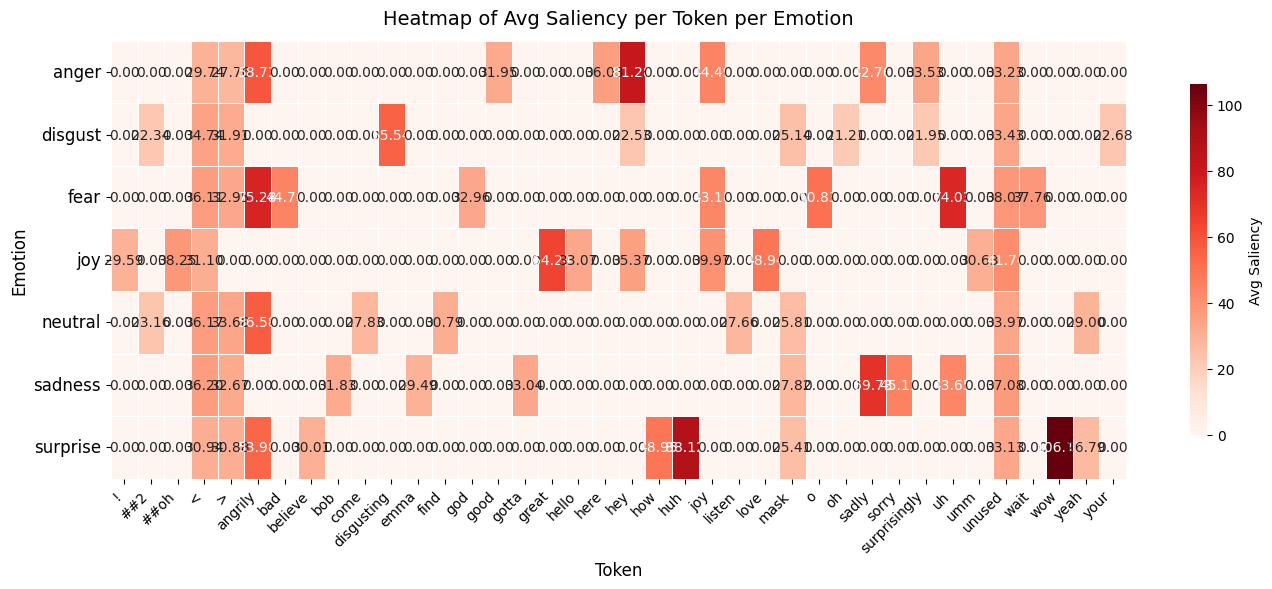

In [ ]:

# Pivot σε DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

# Υποθέτουμε ότι έχεις ήδη:
# df_top_per_emo με στήλες ["emotion","token","avg_saliency"]

# Φτιάχνουμε τον πίνακα heatmap
heat = df_top.pivot(index="emotion", columns="token", values="avg_saliency").fillna(0)

# Δημιούργησε τη φιγούρα με κατάλληλο μέγεθος
plt.figure(figsize=(14, 6))  # π.χ. 14 ίντσες πλάτος, 6 ύψος
ax = sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Avg Saliency"}
)

# Στροφές & μεγέθη ετικετών
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

plt.title("Heatmap of Avg Saliency per Token per Emotion", fontsize=14, pad=12)
plt.xlabel("Token", fontsize=12)
plt.ylabel("Emotion", fontsize=12)
plt.tight_layout()
plt.show()



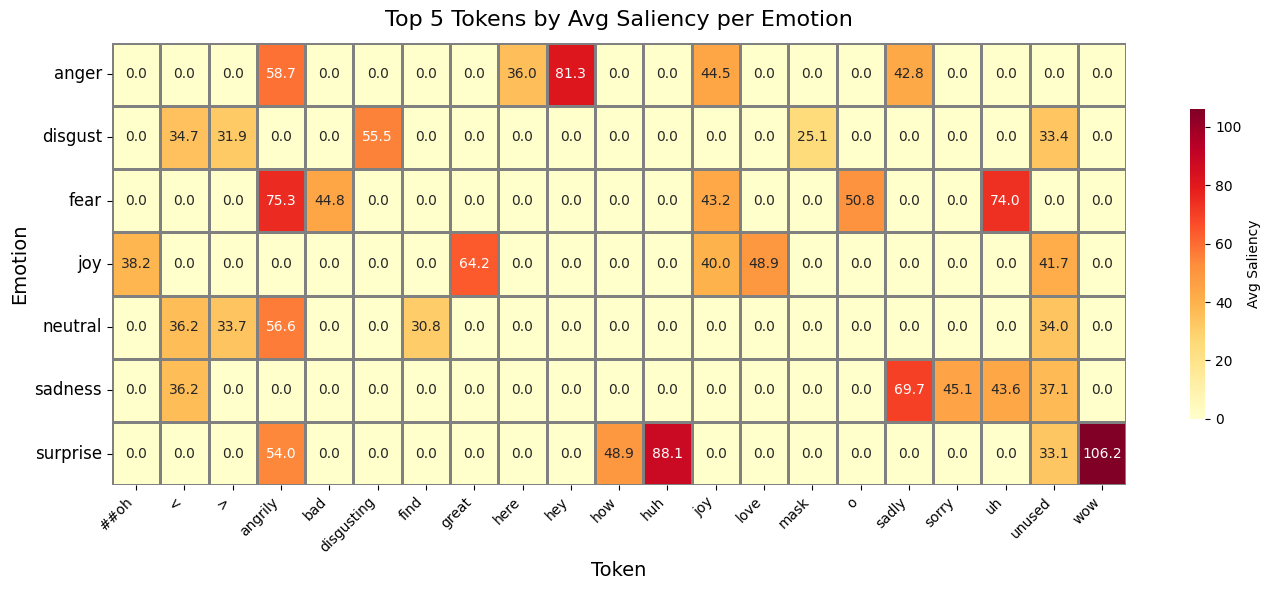

In [ ]:
# ── 1) Recompute top-5 tokens per emotion ──────────────────────────────────
# Assume you have `df_all` from your global explanation step:
# df_all = DataFrame with columns ["emotion","token","count","avg_saliency"]

# Filter out very rare tokens
df_filtered = df_all[df_all["count"] >= 5]

# Sort descending by avg_saliency within each emotion
df_sorted = df_filtered.sort_values(
    ["emotion", "avg_saliency"], ascending=[True, False]
)

# Take top 5 per emotion
df_top5 = df_sorted.groupby("emotion").head(5).reset_index(drop=True)

# ── 2) Pivot to wide format for heatmap ─────────────────────────────────────
heat = df_top5.pivot(
    index="emotion",
    columns="token",
    values="avg_saliency"
).fillna(0)

# ── 3) Plot styled heatmap ────────────────────────────────────────────────
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    heat,
    annot=True,            # show values
    fmt=".1f",             # one decimal place
    cmap="YlOrRd",         # yellow→red colormap
    linewidths=0.8,        # cell borders
    linecolor="gray",
    cbar_kws={"shrink": 0.7, "label": "Avg Saliency"}
)

# Improve axis labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=12
)

plt.title(
    "Top 5 Tokens by Avg Saliency per Emotion",
    fontsize=16,
    pad=12
)
plt.xlabel("Token", fontsize=14)
plt.ylabel("Emotion", fontsize=14)
plt.tight_layout()
plt.show()

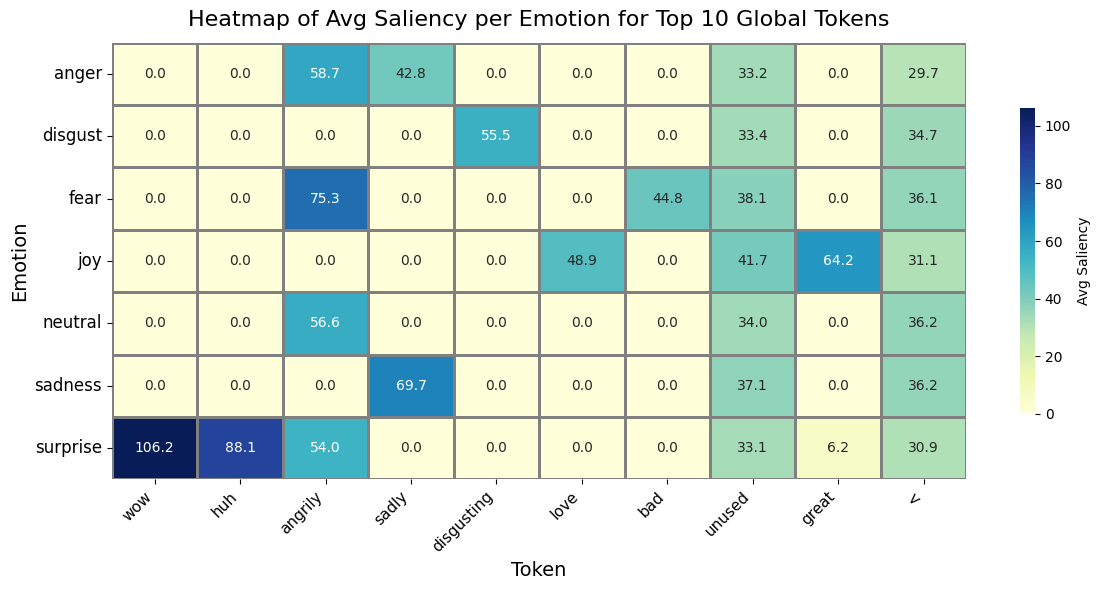

In [ ]:
# ── 1) Compute overall mean saliency per token ────────────────────────────
# Assume `df_all` exists with ["emotion","token","count","avg_saliency"]
# Filter out very rare tokens for stability
df_filtered = df_all[df_all["count"] >= 5]

# Group by token across all emotions
df_global = (
    df_filtered
      .groupby("token")
      .agg(mean_saliency_all=("avg_saliency","mean"))
      .reset_index()
)

# Pick the TOP_N tokens by this overall mean
TOP_N = 10
top_tokens = df_global.nlargest(TOP_N, "mean_saliency_all")["token"].tolist()

# ── 2) Build heatmap matrix (emotions × top_tokens) ───────────────────────
# Pivot your original per-emotion data for only these tokens
heat = (
    df_filtered[df_filtered["token"].isin(top_tokens)]
      .pivot(index="emotion", columns="token", values="avg_saliency")
      .reindex(columns=top_tokens)   # ensure token order matches ranking
      .fillna(0)
)

# ── 3) Plot styled heatmap ────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heat,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.8,
    linecolor="gray",
    cbar_kws={"shrink":0.7, "label":"Avg Saliency"}
)

# Tidy up labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

plt.title(f"Heatmap of Avg Saliency per Emotion for Top {TOP_N} Global Tokens", fontsize=16, pad=12)
plt.xlabel("Token", fontsize=14)
plt.ylabel("Emotion", fontsize=14)
plt.tight_layout()
plt.show()


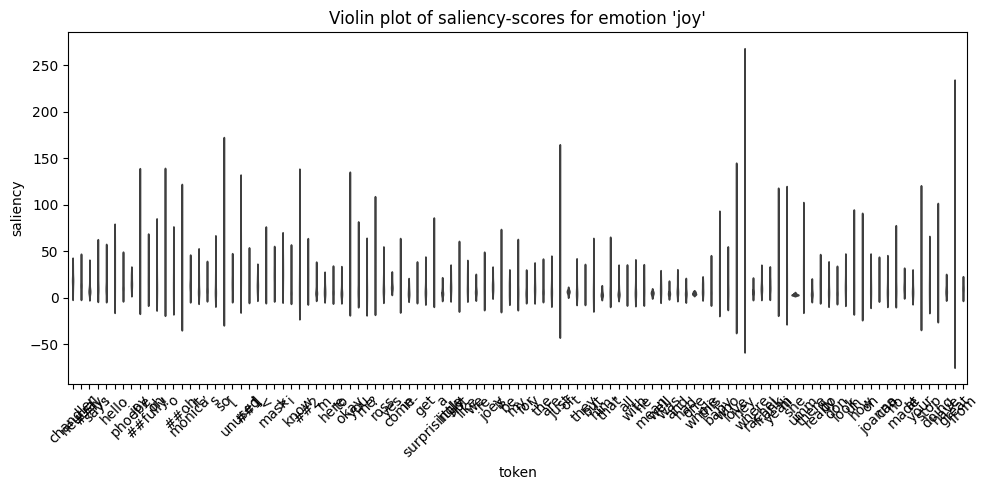

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Διαλέγουμε ένα συγκεκριμένο emotion (π.χ. "joy")
emo = "joy"
# Παίρνουμε τα scores για τα top-tokens αυτού του emotion από το token_saliencies
data = []
for tok, scores in emotion_token_scores[emo].items():
    if len(scores)>=5:
        for s in scores:
            data.append({"token": tok, "saliency": s})
df_box = pd.DataFrame(data)

plt.figure(figsize=(10,5))
sns.violinplot(x="token", y="saliency", data=df_box, inner="quartile")
plt.xticks(rotation=45)
plt.title(f"Violin plot of saliency-scores for emotion '{emo}'")
plt.tight_layout()
plt.show()

In [ ]:
# 2) Saliency function (per Captum docs)
def get_saliency(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    input_ids      = enc["input_ids"]       # [1, seq_len]
    attention_mask = enc["attention_mask"]  # [1, seq_len]

    embeds = model.get_input_embeddings()(input_ids)
    embeds.requires_grad_()

    def forward_emb(inputs_embeds):
        logits = model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        ).logits
        # return logit of the predicted class
        return logits.max(dim=1)[0]

    sal = Saliency(forward_emb)
    atts = sal.attribute(embeds)  # [1, seq_len, hidden_dim]
    scores = atts.abs().sum(dim=-1).squeeze(0).cpu().detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    return tokens, scores

# 3) Prediction helper
def predict_proba(text):
    enc   = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    logits = model(**enc).logits
    return F.softmax(logits, dim=-1).squeeze(0).cpu().detach().numpy()

# 4) Select one utterance
df = pd.read_csv("/content/drive/MyDrive/MELD/dev_for_student_paragraph.csv"  , encoding="utf-8")
idx = np.random.randint(len(df))    # or set idx = 0,1,...
text = df["Utterance"].iloc[idx]
true_label = df["Emotion"].iloc[idx]
print(f"Utterance #{idx} (True: {true_label}):\n{text}\n")

# 5) Compute saliency and original prediction
tokens, saliency_scores = get_saliency(text)
probs = predict_proba(text)
pred_idx   = int(probs.argmax())
pred_label = model.config.id2label[pred_idx]
orig_prob  = float(probs[pred_idx])
print(f"Predicted: {pred_label} (p={orig_prob:.3f})\n")

# 6) For every token (excluding special), mask and recompute
results = []
for i, (tok, sc) in enumerate(zip(tokens, saliency_scores)):
    if tok in tokenizer.all_special_tokens:
        continue
    masked = tokens.copy()
    masked[i] = tokenizer.mask_token
    masked_text = tokenizer.convert_tokens_to_string(masked)
    masked_prob = predict_proba(masked_text)[pred_idx]
    results.append({
        "token": tok,
        "position": i,
        "saliency": round(float(sc),4),
        "orig_prob": round(orig_prob,4),
        "masked_prob": round(float(masked_prob),4),
        "delta": round(orig_prob - float(masked_prob),4)
    })

df_cf = pd.DataFrame(results)
print(df_cf)

# 7) Plot Δ for all tokens
plt.figure(figsize=(max(8, len(df_cf)*0.4), 4))
plt.bar(df_cf["token"], df_cf["delta"], color="salmon", edgecolor="k")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δ Probability")
plt.title(f"Counterfactual Δ for all tokens (Predicted: {pred_label})")
plt.tight_layout()
plt.show()


KeyError: 'Utterance'

Utterance #0:
<s> Phoebe <mask> says: Oh my God, he’s lost it. He’s totally lost it. </s> Monica says: What?

Predicted class index: 6  (p=0.731)

      token  position  orig_prob  masked_prob   delta
0       god        13     0.7309       0.0979  0.6330
1        my        12     0.7309       0.0986  0.6323
2      what        35     0.7309       0.1147  0.6162
3         :        34     0.7309       0.1150  0.6159
4         >         8     0.7309       0.1256  0.6053
5         s        17     0.7309       0.1312  0.5997
6         :        10     0.7309       0.1314  0.5995
7         <         6     0.7309       0.1338  0.5971
8         .        27     0.7309       0.1364  0.5945
9   totally        24     0.7309       0.1369  0.5940
10        ’        16     0.7309       0.1393  0.5916
11       oh        11     0.7309       0.1400  0.5909
12        .        20     0.7309       0.1402  0.5907
13        ?        36     0.7309       0.1405  0.5904
14       it        26     0.7309       0.14

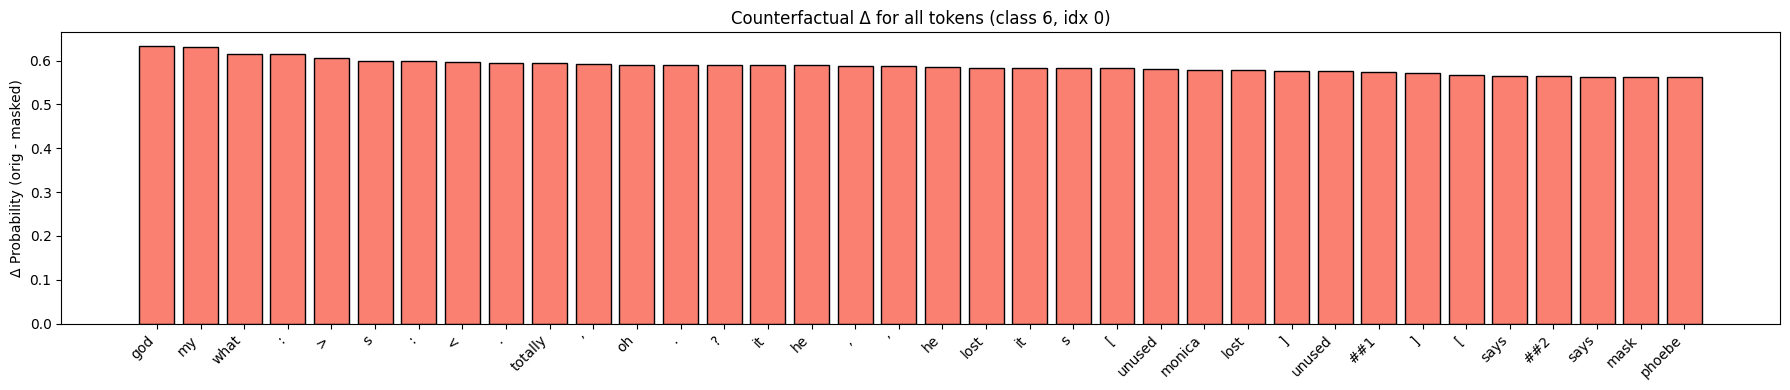

In [ ]:
# ==== Counterfactual saliency (mask-one-token) for Student BERT+FCM ====
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# --- config ---
CSV_PATH = "/content/drive/MyDrive/MELD/dev_for_student_paragraph.csv"  # or train_for_student_paragraph.csv
TEXT_COL = None   # auto-detect: 'student_input' (suggestive) or 'Utterance'
IDX      = 0      # row to explain
MAX_LEN  = 256

device = next(model.parameters()).device  # uses your already-loaded model & tokenizer

# --- marker normalization: <s> ... </s> -> [unused1]/[unused2] (single tokens) ---
def normalize_markers(text: str) -> str:
    text = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    text = re.sub(r"\s*<s>\s*",  " [unused1] ", text)
    return text

# --- FCM masks from token IDs ---
ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=device),
        torch.tensor([qm], device=device),
        torch.tensor([fm], device=device)
    )

# --- predict_proba using YOUR model (FCM masks) ---
@torch.no_grad()
def predict_proba(text: str):
    text = normalize_markers(text)
    enc = tokenizer(text, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"])
    logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
    return F.softmax(logits, dim=-1)[0].detach().cpu().numpy()

# --- saliency via embedding gradients (for info; not required for mask deltas) ---
def get_saliency(text: str):
    text = normalize_markers(text)
    enc = tokenizer(text, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"])

    emb_layer = model.bert.embeddings.word_embeddings
    embeds = emb_layer(enc["input_ids"]).clone().detach().requires_grad_(True)

    def forward_fn(inputs_embeds):
        logits = model(inputs_embeds=inputs_embeds,
                       attention_mask=enc["attention_mask"],
                       past_mask=pm, query_mask=qm, future_mask=fm)
        return logits.max(dim=1)[0]

    # manual saliency (|d logit / d embed|)
    logits = forward_fn(embeds)
    model.zero_grad(set_to_none=True)
    logits.backward()
    grads = embeds.grad  # [1, T, H]
    scores = grads.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()  # [T]
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    return tokens, scores

# --- load text ---
df = pd.read_csv(CSV_PATH)
if TEXT_COL is None:
    TEXT_COL = "student_input" if "student_input" in df.columns else "Utterance"
text = str(df.loc[IDX, TEXT_COL])

print(f"Utterance #{IDX}:\n{text}\n")

# --- original prediction ---
probs = predict_proba(text)
pred_idx = int(np.argmax(probs))
pred_prob = float(probs[pred_idx])
print(f"Predicted class index: {pred_idx}  (p={pred_prob:.3f})\n")

# --- tokenize once; we’ll mask one token at a time and rebuild text ---
text_norm = normalize_markers(text)
enc0 = tokenizer(text_norm, return_tensors="pt",
                 padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
tokens = tokenizer.convert_ids_to_tokens(enc0["input_ids"][0].detach().cpu().tolist())

# tokens to skip from masking
SPECIAL_DROP = set(tokenizer.all_special_tokens) | {"[unused1]", "[unused2]"}

# --- run counterfactual masks ---
results = []
for i, tok in enumerate(tokens):
    if tok in SPECIAL_DROP:
        continue
    masked = tokens.copy()
    masked[i] = tokenizer.mask_token  # replace with [MASK]
    masked_text = tokenizer.convert_tokens_to_string(masked)
    # NOTE: masked_text already includes markers because tokens came after normalization
    masked_probs = predict_proba(masked_text)
    delta = pred_prob - float(masked_probs[pred_idx])
    results.append({
        "token": tok,
        "position": i,
        "orig_prob": round(pred_prob, 4),
        "masked_prob": round(float(masked_probs[pred_idx]), 4),
        "delta": round(delta, 4)
    })

df_cf = pd.DataFrame(results).sort_values("delta", ascending=False).reset_index(drop=True)
print(df_cf.head(20))

# --- plot all deltas ---
plt.figure(figsize=(max(10, 0.5*len(df_cf)), 4))
plt.bar(range(len(df_cf)), df_cf["delta"], color="salmon", edgecolor="k")
plt.xticks(range(len(df_cf)), df_cf["token"], rotation=45, ha="right")
plt.ylabel("Δ Probability (orig - masked)")
plt.title(f"Counterfactual Δ for all tokens (class {pred_idx}, idx {IDX})")
plt.tight_layout()
plt.show()


In [ ]:
# === Interactive counterfactual viewer (auto-detects text column) ===
# Requires: df (loaded), tokenizer, model, get_saliency(text), predict_proba(text)

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import pandas as pd

# pick text column automatically
TEXT_COL = "student_input" if "student_input" in df.columns else (
    "Utterance" if "Utterance" in df.columns else None
)
if TEXT_COL is None:
    raise KeyError(f"No text column found in df. Columns are: {list(df.columns)}; "
                   "expected 'student_input' or 'Utterance'.")

# (Colab) ensure widget manager
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass

def explain_utterance(idx):
    clear_output(wait=True)
    text = str(df.loc[idx, TEXT_COL])
    true = str(df.loc[idx, "Emotion"]) if "Emotion" in df.columns else "N/A"

    # uses your previously defined helpers
    toks, sal = get_saliency(text)
    probs     = predict_proba(text)
    pred_idx  = int(probs.argmax())
    pred_lbl  = getattr(getattr(model, "config", None), "id2label", {}).get(pred_idx, str(pred_idx))
    orig_p    = float(probs[pred_idx])

    # counterfactual Δ by masking one token at a time
    rows = []
    for i, (tok, sc) in enumerate(zip(toks, sal)):
        if tok in tokenizer.all_special_tokens:
            continue
        masked = toks.copy()
        masked[i] = tokenizer.mask_token
        mp = predict_proba(tokenizer.convert_tokens_to_string(masked))[pred_idx]
        rows.append((tok, sc, orig_p - float(mp)))
    df_cf = pd.DataFrame(rows, columns=["token","saliency","delta"])

    display(HTML(f"<b>Utterance #{idx}</b> (True: <i>{true}</i>)<br/>{text}"))
    display(HTML(f"<b>Predicted:</b> {pred_lbl} (p={orig_p:.3f})"))

    plt.figure(figsize=(max(8, len(df_cf)*0.5), 4))
    plt.bar(df_cf["token"], df_cf["delta"], color="salmon", edgecolor="k")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Δ Probability")
    plt.title(f"Counterfactual Δ for Utterance #{idx} ({pred_lbl})")
    plt.tight_layout()
    plt.show()

utter_slider = widgets.IntSlider(
    value=0, min=0, max=len(df)-1, step=1,
    description=f"Row ({TEXT_COL}):"
)
widgets.interact(explain_utterance, idx=utter_slider);



interactive(children=(IntSlider(value=0, description='Row (student_input):', max=1107), Output()), _dom_classe…

In [ ]:
# === Interactive counterfactual viewer (slider + dropdown, robust to column names) ===
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import pandas as pd

# Auto-pick text + label columns
TEXT_COL = "student_input" if "student_input" in df.columns else (
    "Utterance" if "Utterance" in df.columns else None
)
if TEXT_COL is None:
    raise KeyError(f"No text column found in df. Columns: {list(df.columns)}; "
                   "expected 'student_input' or 'Utterance'.")
LABEL_COL = "Emotion" if "Emotion" in df.columns else None

# (Colab) ensure widget manager
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass

# tokens we never mask/show
SPECIAL_DROP = set(tokenizer.all_special_tokens) | {"[unused1]", "[unused2]"}

def explain(idx, mask_token):
    clear_output(wait=True)

    text = str(df.loc[idx, TEXT_COL])
    true = str(df.loc[idx, LABEL_COL]) if LABEL_COL else "N/A"

    # uses your previously defined helpers
    toks, sal = get_saliency(text)
    probs     = predict_proba(text)
    pred_idx  = int(probs.argmax())
    pred_lbl  = getattr(getattr(model, "config", None), "id2label", {}).get(pred_idx, str(pred_idx))
    orig_p    = float(probs[pred_idx])

    # Show utterance & prediction
    display(HTML(f"<b>Row #{idx}</b> (True: <i>{true}</i>)<br/>{text}"))
    display(HTML(f"<b>Predicted:</b> {pred_lbl} (p={orig_p:.3f})"))

    # If a specific token is chosen, mask its first occurrence and report Δ
    if mask_token is not None:
        positions = [i for i, t in enumerate(toks) if t == mask_token]
        if not positions:
            display(HTML(f"<i>Token <code>{mask_token}</code> does not appear in this row.</i>"))
            return
        i = positions[0]
        masked = toks.copy()
        masked[i] = tokenizer.mask_token
        masked_text = tokenizer.convert_tokens_to_string(masked)
        mp = predict_proba(masked_text)[pred_idx]
        delta = orig_p - float(mp)
        display(HTML(
            f"<b>Masking</b> <code>{mask_token}</code> at position {i}: "
            f"new p({pred_lbl}) = {mp:.3f} → Δ = {delta:.3f}"
        ))
        return

    # Otherwise, show full Δ-bar chart over all non-special tokens
    rows = []
    for i, tok in enumerate(toks):
        if tok in SPECIAL_DROP:
            continue
        masked = toks.copy()
        masked[i] = tokenizer.mask_token
        masked_text = tokenizer.convert_tokens_to_string(masked)
        mp = predict_proba(masked_text)[pred_idx]
        rows.append((tok, orig_p - float(mp)))

    if not rows:
        display(HTML("<i>No non-special tokens to plot.</i>"))
        return

    df_cf = pd.DataFrame(rows, columns=["token", "delta"])
    plt.figure(figsize=(max(8, len(df_cf) * 0.45), 3.8))
    plt.bar(df_cf["token"], df_cf["delta"], color="salmon", edgecolor="k")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Δ Probability (orig − masked)")
    plt.title(f"Counterfactual Δ for all tokens (pred: {pred_lbl})")
    plt.tight_layout()
    plt.show()

# Widgets
utter_idx = widgets.IntSlider(value=0, min=0, max=len(df) - 1, step=1, description="Row")
token_dd  = widgets.Dropdown(options=[None], description="Mask token")

def update_tokens(*args):
    text = str(df.loc[utter_idx.value, TEXT_COL])
    toks, _ = get_saliency(text)
    # unique, non-special tokens only
    uniq = []
    seen = set()
    for t in toks:
        if t in SPECIAL_DROP:
            continue
        if t not in seen:
            seen.add(t)
            uniq.append(t)
    token_dd.options = [None] + uniq

utter_idx.observe(update_tokens, names="value")
update_tokens()  # init once

ui  = widgets.HBox([utter_idx, token_dd])
out = widgets.interactive_output(explain, {"idx": utter_idx, "mask_token": token_dd})

display(ui, out)



Output()

Row #0 — True: sadness
<s> Phoebe <mask> says: Oh my God, he’s lost it. He’s totally lost it. </s> Monica says: What?

Predicted: 6 (p = 0.731)

       word    saliency  orig_prob  masked_prob     delta
0       god   70.338280   0.730903     0.082425  0.648477
1        my   46.585487   0.730903     0.084229  0.646674
2      what   11.673609   0.730903     0.099422  0.631480
3         :   17.882610   0.730903     0.101481  0.629422
4         >   36.246887   0.730903     0.102294  0.628609
5         [   15.611851   0.730903     0.110661  0.620242
6         .   31.045067   0.730903     0.112033  0.618870
7         ?   15.812189   0.730903     0.113162  0.617741
8         s   31.716278   0.730903     0.113205  0.617698
9        oh   47.237114   0.730903     0.114170  0.616733
10        :   25.234230   0.730903     0.115612  0.615291
11  unused2   54.377113   0.730903     0.115659  0.615244
12        .   30.386024   0.730903     0.116189  0.614714
13        <   40.449482   0.730903     0.11

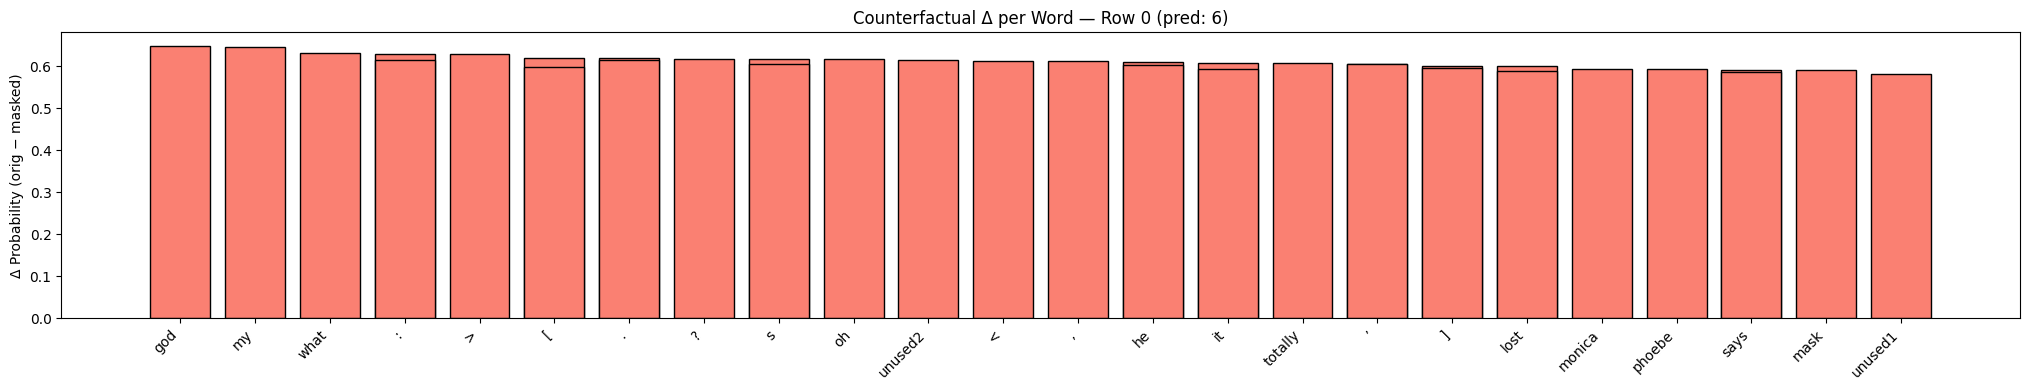

In [ ]:
# ===== Word-level counterfactual saliency for Student BERT+FCM =====
# Drop this cell below the one where you define+load:
#   - model: BERTWithFCM
#   - tokenizer: bert-base-uncased
#   - device: same as model (will infer)

!pip -q install captum

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from captum.attr import Saliency

# ---------- config ----------
# Toggle: use the dev or train student-paragraph split
USE_DEV  = True
BASE_DIR = "/content/drive/MyDrive/MELD"
CSV_PATH = (f"{BASE_DIR}/dev_for_student_paragraph.csv"
            if USE_DEV else f"{BASE_DIR}/train_for_student_paragraph.csv")

TEXT_COL = None    # auto: 'student_input' or 'Utterance'
LABEL_COL = None   # auto: 'Emotion' if present
MAX_LEN  = 256
IDX      = 0       # row to explain

device = next(model.parameters()).device

# ---------- markers & masks ----------
def normalize_markers(text: str) -> str:
    # Support legacy <s> ... </s> and ensure [unused1]/[unused2] are present
    t = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    t = re.sub(r"\s*<s>\s*",  " [unused1] ", t)
    if "[unused1]" not in t and "[unused2]" not in t:
        t = f"[unused1] {t} [unused2]"
    return t

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask, dev):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=dev),
        torch.tensor([qm], device=dev),
        torch.tensor([fm], device=dev)
    )

SPECIAL_DROP = set(tokenizer.all_special_tokens) | {"[unused1]", "[unused2]"}

# ---------- WordPiece merge (BERT) ----------
def merge_subwords(tokens):
    words, positions = [], []
    cur_w, cur_pos = None, []
    for i, tok in enumerate(tokens):
        if tok in SPECIAL_DROP:
            continue
        if tok.startswith("##"):
            if cur_w is None:
                cur_w = tok[2:]
                cur_pos = [i]
            else:
                cur_w += tok[2:]
                cur_pos.append(i)
        else:
            if cur_w is not None:
                words.append(cur_w); positions.append(cur_pos)
            cur_w = tok; cur_pos = [i]
    if cur_w is not None:
        words.append(cur_w); positions.append(cur_pos)
    return words, positions

# ---------- saliency over embeddings (optional signal) ----------
def get_saliency(text):
    t = normalize_markers(text)
    enc = tokenizer(t, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)

    emb_layer = model.bert.embeddings.word_embeddings
    embeds = emb_layer(enc["input_ids"]).clone().detach().requires_grad_(True)

    def forward_emb(inputs_embeds):
        logits = model(inputs_embeds=inputs_embeds,
                       attention_mask=enc["attention_mask"],
                       past_mask=pm, query_mask=qm, future_mask=fm)
        return logits.max(dim=1)[0]  # logit of predicted class

    sal = Saliency(forward_emb)
    logits = forward_emb(embeds)
    model.zero_grad(set_to_none=True)
    logits.backward()
    grads = embeds.grad
    scores = grads.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()
    toks   = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    return toks, scores

# ---------- model probability ----------
@torch.no_grad()
def predict_proba(text):
    t = normalize_markers(text)
    enc = tokenizer(t, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)
    logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
    return torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()

# ---------- data ----------
df = pd.read_csv(CSV_PATH, encoding="utf-8")
TEXT_COL = "student_input" if "student_input" in df.columns else (
    "Utterance" if "Utterance" in df.columns else None
)
if TEXT_COL is None:
    raise KeyError(f"No text column in df. Columns={list(df.columns)}")
LABEL_COL = "Emotion" if "Emotion" in df.columns else None

text = str(df.loc[IDX, TEXT_COL])
true = str(df.loc[IDX, LABEL_COL]) if LABEL_COL else "N/A"
print(f"Row #{IDX} — True: {true}\n{text}\n")

# ---------- tokenization once for counterfactual masking ----------
text_norm = normalize_markers(text)
enc0 = tokenizer(text_norm, return_tensors="pt",
                 padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
tokens = tokenizer.convert_ids_to_tokens(enc0["input_ids"][0].detach().cpu().tolist())

# ---------- token-level saliency & merge to words ----------
toks, sal_scores = get_saliency(text)
words, positions = merge_subwords(toks)

# ---------- original prediction ----------
probs     = predict_proba(text)
pred_idx  = int(np.argmax(probs))
pred_lbl  = getattr(getattr(model, "config", None), "id2label", {}).get(pred_idx, str(pred_idx))
orig_prob = float(probs[pred_idx])
print(f"Predicted: {pred_lbl} (p = {orig_prob:.3f})\n")

# ---------- per-word counterfactual Δ ----------
records = []
for w, pos_list in zip(words, positions):
    word_saliency = float(np.sum(sal_scores[pos_list]))
    masked = toks.copy()
    for p in pos_list:
        masked[p] = tokenizer.mask_token
    masked_text  = tokenizer.convert_tokens_to_string(masked)
    masked_prob  = predict_proba(masked_text)[pred_idx]
    delta        = orig_prob - float(masked_prob)
    records.append({
        "word": w,
        "saliency": word_saliency,
        "orig_prob": orig_prob,
        "masked_prob": float(masked_prob),
        "delta": delta
    })

df_explain = pd.DataFrame(records).sort_values("delta", ascending=False).reset_index(drop=True)
print(df_explain)

# ---------- plot ----------
plt.figure(figsize=(max(8, len(df_explain)*0.6), 4))
plt.bar(df_explain["word"], df_explain["delta"], color="salmon", edgecolor="k")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δ Probability (orig − masked)")
plt.title(f"Counterfactual Δ per Word — Row {IDX} (pred: {pred_lbl})")
plt.tight_layout()
plt.show()



Row #0 — True: sadness
<s> Phoebe <mask> says: Oh my God, he’s lost it. He’s totally lost it. </s> Monica says: What?

Predicted: 6 (p=0.731)

       word    saliency  orig_prob  masked_prob     delta
0   totally  112.122177   0.730903     0.663874  0.067028
1        my   46.585487   0.730903     0.704267  0.026636
2         .   30.386024   0.730903     0.765601 -0.034698
3         ?   15.812189   0.730903     0.806600 -0.075697
4         :   25.234230   0.730903     0.814382 -0.083480
5         :   17.882610   0.730903     0.819981 -0.089079
6       god   70.338280   0.730903     0.838630 -0.107728
7         <   40.449482   0.730903     0.849440 -0.118538
8        it   30.393261   0.730903     0.852531 -0.121629
9         s   31.716278   0.730903     0.856352 -0.125449
10   phoebe   45.749397   0.730903     0.857406 -0.126503
11       oh   47.237114   0.730903     0.857996 -0.127094
12        ]   11.310280   0.730903     0.858277 -0.127374
13   monica   33.188015   0.730903     0.8601

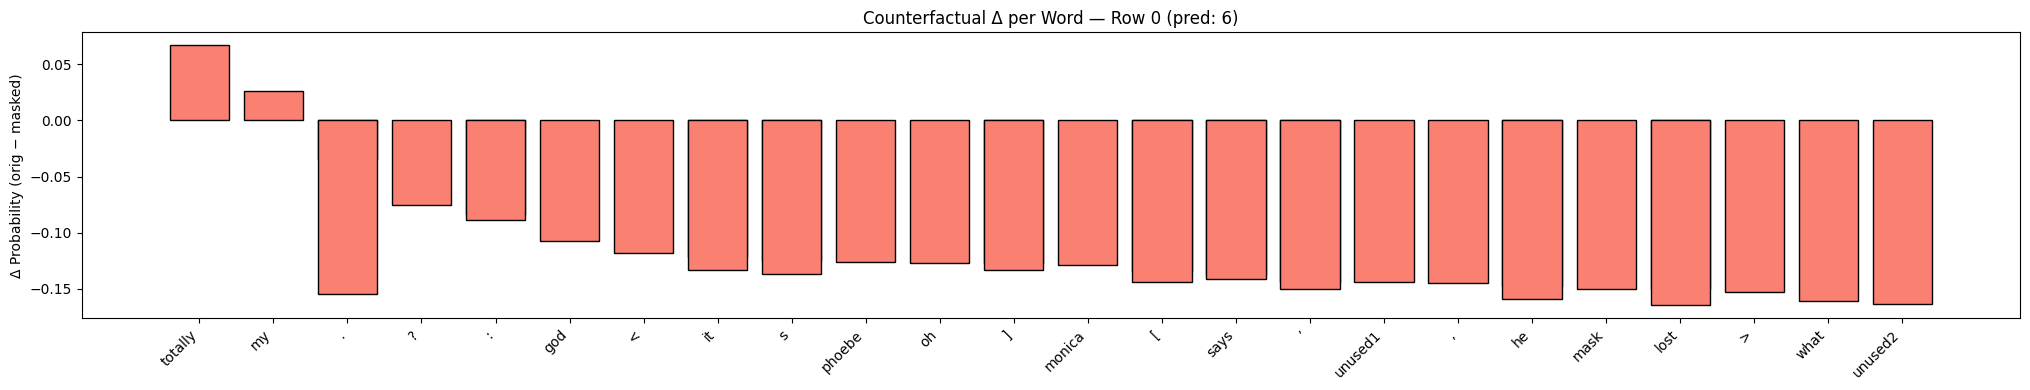

In [ ]:
# ===== Word-level counterfactual saliency for Student BERT+FCM (fixed) =====
# Requires: model (BERTWithFCM), tokenizer (bert-base-uncased), device
!pip -q install captum

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from captum.attr import Saliency

# ---------- config ----------
USE_DEV  = True
BASE_DIR = "/content/drive/MyDrive/MELD"
CSV_PATH = (f"{BASE_DIR}/dev_for_student_paragraph.csv"
            if USE_DEV else f"{BASE_DIR}/train_for_student_paragraph.csv")
MAX_LEN  = 256
IDX      = 0       # row to explain

device = next(model.parameters()).device

# ---------- helpers: markers & FCM masks ----------
def normalize_markers(text: str) -> str:
    # convert legacy <s> … </s> and ensure markers present
    t = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    t = re.sub(r"\s*<s>\s*",  " [unused1] ", t)
    if "[unused1]" not in t or "[unused2]" not in t:
        t = f"[unused1] {t} [unused2]"
    return t

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask, dev):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=dev),
        torch.tensor([qm], device=dev),
        torch.tensor([fm], device=dev)
    )

SPECIAL_DROP = set(tokenizer.all_special_tokens) | {"[unused1]", "[unused2]"}

# ---------- WordPiece merge (BERT) ----------
def merge_to_words(tokens):
    words, word_token_indices = [], []
    cur_word = None; cur_idx = []
    for i, tok in enumerate(tokens):
        if tok in SPECIAL_DROP:
            if cur_word is not None:
                words.append(cur_word); word_token_indices.append(cur_idx)
                cur_word, cur_idx = None, []
            continue
        if tok.startswith("##"):
            if cur_word is None:
                cur_word = tok[2:]; cur_idx = [i]
            else:
                cur_word += tok[2:]; cur_idx.append(i)
        else:
            if cur_word is not None:
                words.append(cur_word); word_token_indices.append(cur_idx)
            cur_word = tok; cur_idx = [i]
    if cur_word is not None:
        words.append(cur_word); word_token_indices.append(cur_idx)
    return words, word_token_indices

# ---------- saliency on embeddings (uses backbone embeddings) ----------
def get_saliency(text):
    t = normalize_markers(text)
    enc = tokenizer(t, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)

    # embeddings from the BERT backbone
    emb_layer = model.bert.embeddings.word_embeddings
    embeds = emb_layer(enc["input_ids"]).clone().detach().requires_grad_(True)

    def forward_emb(inputs_embeds):
        logits = model(inputs_embeds=inputs_embeds,
                       attention_mask=enc["attention_mask"],
                       past_mask=pm, query_mask=qm, future_mask=fm)
        # predicted-class logit
        return logits.max(dim=1)[0]

    sal = Saliency(forward_emb)
    out_logit = forward_emb(embeds)               # build graph
    model.zero_grad(set_to_none=True)
    out_logit.backward(torch.ones_like(out_logit))# seed grad
    grads  = embeds.grad                          # [1, T, H]
    scores = grads.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()  # [T]
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    return enc["input_ids"][0].detach().cpu().tolist(), tokens, scores

# ---------- prediction ----------
@torch.no_grad()
def predict_proba(text):
    t = normalize_markers(text)
    enc = tokenizer(t, return_tensors="pt",
                    padding="max_length", truncation=True, max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: del enc["token_type_ids"]
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)
    logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
    return torch.softmax(logits, dim=-1)[0].cpu().numpy()

# ---------- data ----------
df = pd.read_csv(CSV_PATH, encoding="utf-8")
TEXT_COL = "student_input" if "student_input" in df.columns else (
    "Utterance" if "Utterance" in df.columns else None
)
if TEXT_COL is None:
    raise KeyError(f"No text column in df. Columns={list(df.columns)}")
LABEL_COL = "Emotion" if "Emotion" in df.columns else None

text = str(df.loc[IDX, TEXT_COL])
true = str(df.loc[IDX, LABEL_COL]) if LABEL_COL else "N/A"
print(f"Row #{IDX} — True: {true}\n{text}\n")

# ---------- saliency + merge ----------
input_ids, toks, sal_scores = get_saliency(text)
words, word_token_indices   = merge_to_words(toks)

# ---------- original prediction ----------
probs     = predict_proba(text)
pred_idx  = int(np.argmax(probs))
pred_lbl  = getattr(getattr(model, "config", None), "id2label", {}).get(pred_idx, str(pred_idx))
orig_prob = float(probs[pred_idx])
print(f"Predicted: {pred_lbl} (p={orig_prob:.3f})\n")

# ---------- per-word counterfactual Δ ----------
records = []
for w, idxs in zip(words, word_token_indices):
    word_sal = float(np.sum(sal_scores[idxs]))

    # mask all subword tokens for this word in the ORIGINAL tokenization
    masked_ids = input_ids.copy()
    for j in idxs:
        masked_ids[j] = tokenizer.mask_token_id
    masked_text  = tokenizer.decode(masked_ids, skip_special_tokens=True)
    masked_prob  = predict_proba(masked_text)[pred_idx]
    records.append({
        "word": w,
        "saliency": word_sal,
        "orig_prob": orig_prob,
        "masked_prob": float(masked_prob),
        "delta": orig_prob - float(masked_prob)
    })

df_explain = pd.DataFrame(records).sort_values("delta", ascending=False).reset_index(drop=True)
print(df_explain)

# ---------- plot ----------
plt.figure(figsize=(max(8, len(df_explain)*0.6), 4))
plt.bar(df_explain["word"], df_explain["delta"], color="salmon", edgecolor="k")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δ Probability (orig − masked)")
plt.title(f"Counterfactual Δ per Word — Row {IDX} (pred: {pred_lbl})")
plt.tight_layout()
plt.show()


In [ ]:
# 2) Compute token‐level saliency + return offsets
def get_saliency_and_offsets(text):
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        return_offsets_mapping=True
    ).to(device)

    input_ids       = enc["input_ids"]           # [1, seq_len]
    attention_mask  = enc["attention_mask"]      # [1, seq_len]
    offsets         = enc["offset_mapping"][0].cpu().tolist()  # list of (start,end)
    tokens          = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    # embeddings + grad
    embeds = model.get_input_embeddings()(input_ids)
    embeds.requires_grad_()

    def forward_emb(inputs_embeds):
        logits = model(
          inputs_embeds=inputs_embeds,
          attention_mask=attention_mask
        ).logits
        return logits.max(dim=1)[0]

    sal = Saliency(forward_emb)
    atts = sal.attribute(embeds)                   # [1, seq_len, hidden_dim]
    scores = atts.abs().sum(dim=-1).squeeze(0)      # [seq_len]

    return tokens, scores.cpu().numpy(), offsets

# 3) Group token indices by original words via regex on text
def group_tokens_by_word(text, offsets):
    # find spans of each whitespace-separated word
    spans = [(m.start(), m.end(), m.group()) for m in re.finditer(r'\S+', text)]
    token2word = {}
    for tidx, (start, end) in enumerate(offsets):
        # skip special tokens (offsets of (0,0))
        if start == 0 and end == 0:
            continue
        # find which span this token starts in
        for widx, (wstart, wend, wstr) in enumerate(spans):
            if start >= wstart and start < wend:
                token2word.setdefault(widx, []).append(tidx)
                break

    words = []
    positions = []
    for widx, toks_idxs in sorted(token2word.items()):
        _, _, wstr = spans[widx]
        words.append(wstr)
        positions.append(toks_idxs)
    return words, positions

# 4) Prediction helper
def predict_proba(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**enc).logits
    return F.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

# 5) Load your dataset
df = pd.read_csv("train_sent_emo_cleaned_processed.csv", encoding="utf-8")

# 6) Pick an utterance
idx  = 0  # change as needed
text = df["Utterance"].iloc[idx]
true = df["Emotion"].iloc[idx]
print(f"Utterance #{idx} (True: {true}):\n{text}\n")

# 7) Saliency & offsets → group into words
tokens, sal_scores, offsets = get_saliency_and_offsets(text)
words, word_positions       = group_tokens_by_word(text, offsets)

# 8) Original prediction
probs     = predict_proba(text)
pred_idx  = int(np.argmax(probs))
pred_lbl  = model.config.id2label[pred_idx]
orig_prob = float(probs[pred_idx])
print(f"Predicted: {pred_lbl} (p = {orig_prob:.3f})\n")

# 9) Counterfactual per word
records = []
for w, pos_list in zip(words, word_positions):
    # sum the saliency scores for all subwords of this word
    word_saliency = float(sal_scores[pos_list].sum())
    # mask those positions
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding=True)["input_ids"][0].tolist()
    for tidx in pos_list:
        input_ids[tidx] = tokenizer.mask_token_id
    masked_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    masked_prob = predict_proba(masked_text)[pred_idx]
    delta       = orig_prob - float(masked_prob)

    records.append({
        "word": w,
        "saliency": word_saliency,
        "orig_prob": orig_prob,
        "masked_prob": float(masked_prob),
        "delta": delta
    })

df_explain = pd.DataFrame(records)
print(df_explain)

# 10) Plot Δ for each word
plt.figure(figsize=(max(8, len(df_explain)*0.5), 4))
plt.bar(df_explain["word"], df_explain["delta"], color="salmon", edgecolor="k")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δ Probability")
plt.title(f"Counterfactual Δ per Word for Utterance #{idx} ({pred_lbl})")
plt.tight_layout()
plt.show()


Row #0 — True: sadness
 [unused1] Phoebe <mask> says: Oh my God, he’s lost it. He’s totally lost it. [unused2] Monica says: What?

Predicted: 6  (p=0.731)

       word    saliency  orig_prob  masked_prob     delta
0        my   46.585487   0.730903     0.298191  0.432712
1   totally  112.122177   0.730903     0.345386  0.385516
2      God,   86.906044   0.730903     0.425241  0.305662
3     says:   55.525879   0.730903     0.465173  0.265729
4     says:   41.352142   0.730903     0.473890  0.257012
5       it.   61.438328   0.730903     0.545262  0.185640
6    <mask>  117.968857   0.730903     0.559633  0.171270
7    Monica   33.188015   0.730903     0.566975  0.163927
8     What?   27.485798   0.730903     0.567284  0.163619
9    Phoebe   45.749397   0.730903     0.584545  0.146358
10      it.   71.519173   0.730903     0.605870  0.125032
11     he’s   75.942093   0.730903     0.612629  0.118273
12       Oh   47.237114   0.730903     0.617510  0.113393
13     He’s   69.202492   0.7309

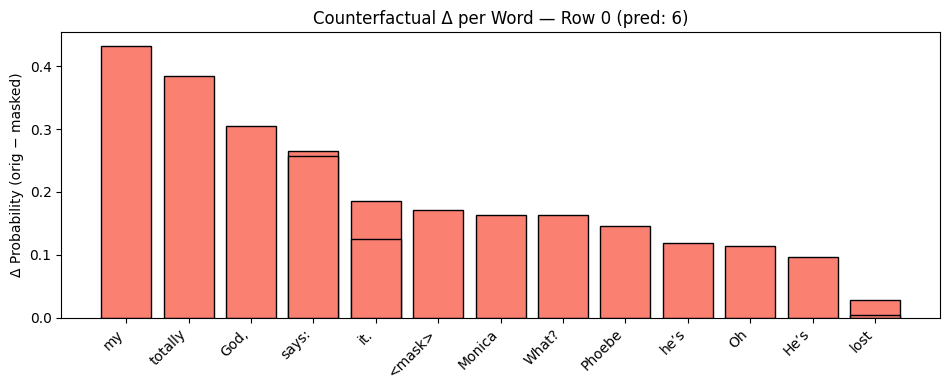

In [ ]:
# ==== Word-level saliency + counterfactuals for Student BERT+FCM (markers-aware) ====
!pip -q install captum

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from captum.attr import Saliency

# ---------------- Config ----------------
USE_DEV  = True
BASE_DIR = "/content/drive/MyDrive/MELD"
CSV_PATH = f"{BASE_DIR}/dev_for_student_paragraph.csv" if USE_DEV else f"{BASE_DIR}/train_for_student_paragraph.csv"
MAX_LEN  = 256
IDX      = 0  # row to explain

device = next(model.parameters()).device

# ---------------- Markers & FCM masks ----------------
def normalize_markers(text: str) -> str:
    # convert legacy <s> ... </s> and make sure both markers exist
    t = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    t = re.sub(r"\s*<s>\s*",  " [unused1] ", t)
    if "[unused1]" not in t or "[unused2]" not in t:
        t = f"[unused1] {t} [unused2]"
    return t

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask, dev):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        # fallback: everything is QUERY
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=dev),
        torch.tensor([qm], device=dev),
        torch.tensor([fm], device=dev)
    )

# ---------------- Token saliency + offsets ----------------
def get_saliency_and_offsets(text):
    t = normalize_markers(text)
    enc = tokenizer(
        t,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_offsets_mapping=True
    )
    # keep a CPU copy of offsets before moving to device
    offsets = enc["offset_mapping"][0].tolist()
    # move the rest to device
    enc = {k: (v.to(device) if hasattr(v, "to") else v) for k, v in enc.items()}
    if "token_type_ids" in enc: enc.pop("token_type_ids")

    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)

    # embeddings from backbone
    emb_layer = model.bert.embeddings.word_embeddings
    embeds = emb_layer(enc["input_ids"]).clone().detach().requires_grad_(True)

    def forward_emb(inputs_embeds):
        logits = model(inputs_embeds=inputs_embeds,
                       attention_mask=enc["attention_mask"],
                       past_mask=pm, query_mask=qm, future_mask=fm)
        # predicted-class logit
        return logits.max(dim=1)[0]

    sal = Saliency(forward_emb)
    out_logit = forward_emb(embeds)                   # build graph
    model.zero_grad(set_to_none=True)
    out_logit.backward(torch.ones_like(out_logit))    # seed grad
    grads  = embeds.grad                              # [1, T, H]
    scores = grads.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()  # [T]
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    ids    = enc["input_ids"][0].detach().cpu().tolist()
    attn   = enc["attention_mask"][0].detach().cpu().tolist()
    return ids, tokens, scores, offsets, attn

# ---------------- Group token indices into words (via offsets) ----------------
def group_tokens_by_word(text_norm, offsets):
    # words (non-whitespace spans) in *normalized* text t
    spans = [(m.start(), m.end(), m.group()) for m in re.finditer(r"\S+", text_norm)]
    token2word = {}
    for tidx, (start, end) in enumerate(offsets):
        # special tokens (CLS/SEP/unused) usually have (0,0)
        if start == 0 and end == 0:
            continue
        for widx, (wstart, wend, wstr) in enumerate(spans):
            if wstart <= start < wend:
                token2word.setdefault(widx, []).append(tidx)
                break
    words, positions = [], []
    for widx in sorted(token2word.keys()):
        _, _, wstr = spans[widx]
        # drop explicit marker strings from words list
        if wstr in ("[unused1]", "[unused2]"):
            continue
        words.append(wstr)
        positions.append(token2word[widx])
    return words, positions

# ---------------- Model prediction helpers ----------------
@torch.no_grad()
def predict_proba(text):
    t = normalize_markers(text)
    enc = tokenizer(t, return_tensors="pt",
                    truncation=True, padding="max_length", max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: enc.pop("token_type_ids")
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)
    logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
    return torch.softmax(logits, dim=-1)[0].cpu().numpy()

@torch.no_grad()
def predict_proba_from_ids(ids_list, attn_list):
    # build tensors directly from edited IDs to preserve markers
    input_ids      = torch.tensor([ids_list], device=device)
    attention_mask = torch.tensor([attn_list], device=device)
    pm, qm, fm     = fcm_masks_from_ids(input_ids, attention_mask, device)
    logits = model(input_ids=input_ids,
                   attention_mask=attention_mask,
                   past_mask=pm, query_mask=qm, future_mask=fm)
    return torch.softmax(logits, dim=-1)[0].cpu().numpy()

# ---------------- Load data & pick a row ----------------
df = pd.read_csv(CSV_PATH, encoding="utf-8")
TEXT_COL  = "student_input" if "student_input" in df.columns else ("Utterance" if "Utterance" in df.columns else None)
LABEL_COL = "Emotion" if "Emotion" in df.columns else None
if TEXT_COL is None:
    raise KeyError(f"No text column in {CSV_PATH}. Found: {list(df.columns)}")

raw_text = str(df.loc[IDX, TEXT_COL])
gold     = str(df.loc[IDX, LABEL_COL]) if LABEL_COL else "N/A"
text     = normalize_markers(raw_text)  # work on normalized text
print(f"Row #{IDX} — True: {gold}\n{text}\n")

# ---------------- Saliency + grouping ----------------
ids, toks, sal_scores, offsets, attn = get_saliency_and_offsets(text)
words, word_positions = group_tokens_by_word(text, offsets)

# ---------------- Original prediction ----------------
probs     = predict_proba(text)
pred_idx  = int(np.argmax(probs))
pred_lbl  = getattr(getattr(model, "config", None), "id2label", {}).get(pred_idx, str(pred_idx))
orig_prob = float(probs[pred_idx])
print(f"Predicted: {pred_lbl}  (p={orig_prob:.3f})\n")

# ---------------- Counterfactual per word (mask by IDs) ----------------
records = []
for w, pos_list in zip(words, word_positions):
    # sum saliency over all subword tokens that form the word
    word_sal = float(np.sum(sal_scores[pos_list]))

    # mask those token IDs (keep markers & specials intact)
    masked_ids = ids.copy()
    for tidx in pos_list:
        masked_ids[tidx] = tokenizer.mask_token_id

    masked_probs = predict_proba_from_ids(masked_ids, attn)
    delta        = orig_prob - float(masked_probs[pred_idx])

    records.append({
        "word": w,
        "saliency": word_sal,
        "orig_prob": orig_prob,
        "masked_prob": float(masked_probs[pred_idx]),
        "delta": delta
    })

df_explain = pd.DataFrame(records).sort_values("delta", ascending=False).reset_index(drop=True)
print(df_explain)

# ---------------- Plot ----------------
plt.figure(figsize=(max(8, len(df_explain)*0.6), 4))
plt.bar(df_explain["word"], df_explain["delta"], color="salmon", edgecolor="k")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δ Probability (orig − masked)")
plt.title(f"Counterfactual Δ per Word — Row {IDX} (pred: {pred_lbl})")
plt.tight_layout()
plt.show()


In [ ]:
# === Interactive word-level counterfactuals for Student BERT+FCM (markers-aware) ===
# Requires: model (BERTWithFCM), tokenizer (bert-base-uncased), device (cuda/cpu)

!pip -q install captum ipywidgets
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn.functional as F
from captum.attr import Saliency
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# ---------------- Config ----------------
USE_DEV  = True
BASE_DIR = "/content/drive/MyDrive/MELD"
CSV_PATH = f"{BASE_DIR}/dev_for_student_paragraph.csv" if USE_DEV else f"{BASE_DIR}/train_for_student_paragraph.csv"
MAX_LEN  = 256

device = next(model.parameters()).device

# ---------------- Markers & FCM masks ----------------
def normalize_markers(text: str) -> str:
    # convert legacy <s> ... </s> and ensure markers exist
    t = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    t = re.sub(r"\s*<s>\s*",  " [unused1] ", t)
    if "[unused1]" not in t or "[unused2]" not in t:
        t = f"[unused1] {t} [unused2]"
    return t

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")
SPECIAL_DROP = set(tokenizer.all_special_tokens) | {"[unused1]","[unused2]"}

def fcm_masks_from_ids(input_ids, attention_mask, dev):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=dev),
        torch.tensor([qm], device=dev),
        torch.tensor([fm], device=dev),
    )

# ---------------- Token saliency + offsets ----------------
def get_saliency_and_offsets(text):
    t = normalize_markers(text)
    enc = tokenizer(
        t,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_offsets_mapping=True
    )
    offsets = enc["offset_mapping"][0].tolist()  # keep on CPU for grouping
    enc = {k: (v.to(device) if hasattr(v, "to") else v) for k, v in enc.items()}
    if "token_type_ids" in enc: enc.pop("token_type_ids")

    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)

    emb_layer = model.bert.embeddings.word_embeddings
    embeds = emb_layer(enc["input_ids"]).clone().detach().requires_grad_(True)

    def forward_emb(inputs_embeds):
        logits = model(inputs_embeds=inputs_embeds,
                       attention_mask=enc["attention_mask"],
                       past_mask=pm, query_mask=qm, future_mask=fm)
        return logits.max(dim=1)[0]  # predicted-class logit

    sal = Saliency(forward_emb)
    out_logit = forward_emb(embeds)                 # build graph
    model.zero_grad(set_to_none=True)
    out_logit.backward(torch.ones_like(out_logit))  # seed grad
    grads  = embeds.grad
    scores = grads.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()  # [T]
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    ids    = enc["input_ids"][0].detach().cpu().tolist()
    attn   = enc["attention_mask"][0].detach().cpu().tolist()
    return t, ids, attn, tokens, scores, offsets

# ---------------- Group token indices to words (via offsets on normalized text) ----------------
def reconstruct_words(text_norm, offsets):
    # words or punctuation blocks in normalized text
    spans = [(m.start(), m.end(), m.group()) for m in re.finditer(r"\w+|[^\w\s]+", text_norm)]
    token2word = {}
    for tidx, (start, end) in enumerate(offsets):
        if start == 0 and end == 0:
            continue
        for widx, (wstart, wend, _) in enumerate(spans):
            if wstart <= start < wend:
                token2word.setdefault(widx, []).append(tidx)
                break
    words, positions = [], []
    for widx in sorted(token2word.keys()):
        _, _, wstr = spans[widx]
        if wstr in ("[unused1]","[unused2]"):  # don't present markers as words
            continue
        words.append(wstr)
        positions.append(token2word[widx])
    return words, positions

# ---------------- Predictions ----------------
@torch.no_grad()
def predict_proba(text):
    t = normalize_markers(text)
    enc = tokenizer(t, return_tensors="pt",
                    truncation=True, padding="max_length", max_length=MAX_LEN).to(device)
    if "token_type_ids" in enc: enc.pop("token_type_ids")
    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)
    logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
    return torch.softmax(logits, dim=-1)[0].cpu().numpy()

@torch.no_grad()
def predict_proba_from_ids(ids_list, attn_list):
    input_ids      = torch.tensor([ids_list], device=device)
    attention_mask = torch.tensor([attn_list], device=device)
    pm, qm, fm     = fcm_masks_from_ids(input_ids, attention_mask, device)
    logits = model(input_ids=input_ids,
                   attention_mask=attention_mask,
                   past_mask=pm, query_mask=qm, future_mask=fm)
    return torch.softmax(logits, dim=-1)[0].cpu().numpy()

# ---------------- Load data ----------------
df = pd.read_csv(CSV_PATH, encoding="utf-8")
TEXT_COL  = "student_input" if "student_input" in df.columns else ("Utterance" if "Utterance" in df.columns else None)
LABEL_COL = "Emotion" if "Emotion" in df.columns else None
if TEXT_COL is None:
    raise KeyError(f"No text column in {CSV_PATH}. Found: {list(df.columns)}")

# ---------------- Interactive explain ----------------
def explain(idx, mask_word):
    clear_output(wait=True)

    raw_text = str(df.loc[idx, TEXT_COL])
    gold     = str(df.loc[idx, LABEL_COL]) if LABEL_COL else "N/A"

    # saliency & grouping on normalized text (the exact input to the model)
    text_norm, ids, attn, toks, sal_scores, offsets = get_saliency_and_offsets(raw_text)
    words, positions = reconstruct_words(text_norm, offsets)

    # original prediction
    probs     = predict_proba(raw_text)
    pred_idx  = int(np.argmax(probs))
    pred_lbl  = getattr(getattr(model, "config", None), "id2label", {}).get(pred_idx, str(pred_idx))
    orig_prob = float(probs[pred_idx])

    display(HTML(f"<b>Row #{idx}</b> (True: <i>{gold}</i>)<br/>{text_norm}"))
    display(HTML(f"<b>Predicted:</b> {pred_lbl} (p={orig_prob:.3f})"))

    if mask_word is not None:
        if mask_word not in words:
            print(f"Word {mask_word!r} not found.")
            return
        wi = words.index(mask_word)
        pos_list = positions[wi]

        # mask by IDs to preserve markers and attention
        masked_ids = ids.copy()
        for p in pos_list:
            masked_ids[p] = tokenizer.mask_token_id
        masked_probs = predict_proba_from_ids(masked_ids, attn)
        delta        = orig_prob - float(masked_probs[pred_idx])

        display(HTML(
            f"<b>Masking word</b> <code>{mask_word}</code>: "
            f"new p({pred_lbl}) = {masked_probs[pred_idx]:.3f} → Δ = {delta:.3f}"
        ))
    else:
        # full bar chart of per-word Δ
        records = []
        for w, pos_list in zip(words, positions):
            # skip if any token is a special (shouldn't happen here, but safe)
            if any(toks[p] in SPECIAL_DROP for p in pos_list):
                continue
            masked_ids = ids.copy()
            for p in pos_list:
                masked_ids[p] = tokenizer.mask_token_id
            masked_probs = predict_proba_from_ids(masked_ids, attn)
            records.append((w, orig_prob - float(masked_probs[pred_idx])))

        df_cf = pd.DataFrame(records, columns=["word","delta"])
        plt.figure(figsize=(max(8, len(df_cf)*0.35), 3.5))
        plt.bar(df_cf["word"], df_cf["delta"], color="salmon", edgecolor="k")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Δ Probability")
        plt.title(f"Counterfactual Δ per Word ({pred_lbl})")
        plt.tight_layout()
        plt.show()

# widgets
utter_idx = widgets.IntSlider(0, 0, len(df)-1, description="Utterance")
word_dd   = widgets.Dropdown(options=[None], description="Mask Word")

def update_word_options(*args):
    raw_text = str(df.loc[utter_idx.value, TEXT_COL])
    text_norm, ids, attn, toks, sal_scores, offsets = get_saliency_and_offsets(raw_text)
    words, _ = reconstruct_words(text_norm, offsets)
    word_dd.options = [None] + words

utter_idx.observe(update_word_options, names="value")
update_word_options()

ui  = widgets.HBox([utter_idx, word_dd])
out = widgets.interactive_output(explain, {"idx": utter_idx, "mask_word": word_dd})
display(ui, out)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.0 MB/s eta 0:00:00


Output()

Utterance #0 (True: sadness):
<s> Phoebe <mask> says: Oh my God, he’s lost it. He’s totally lost it. </s> Monica says: What?

Predicted: 6


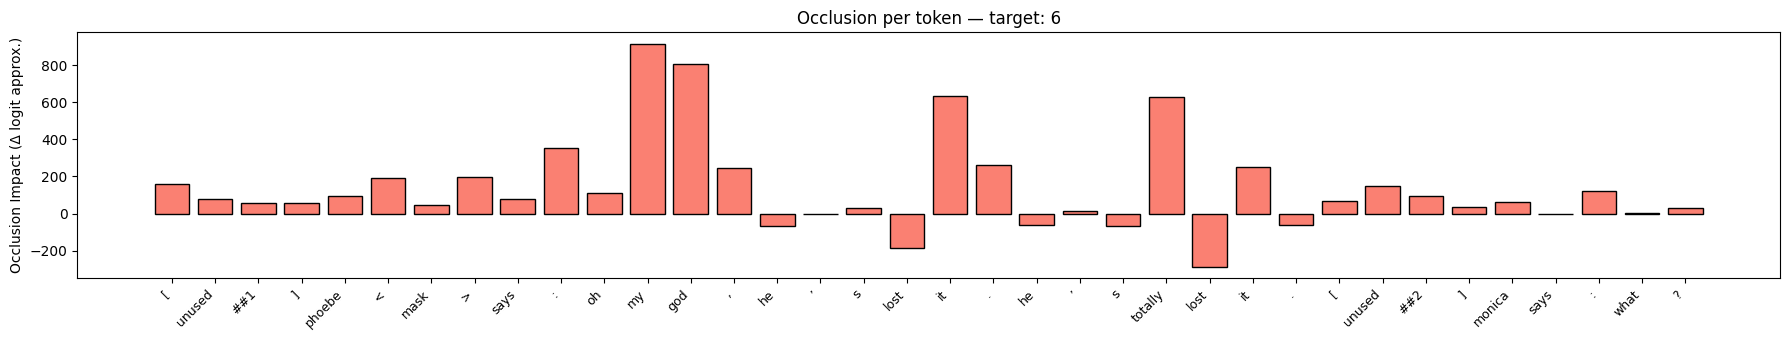

In [ ]:
# ==== Occlusion explanations for Student BERT+FCM (drop-in cell) ====
# Requires: `model` (BERTWithFCM), `tokenizer` (bert-base-uncased), `device`

!pip -q install captum

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn.functional as F
from captum.attr import Occlusion
from IPython.display import display, HTML

# ---------- config ----------
BASE_DIR  = "/content/drive/MyDrive/MELD"
CSV_PATH  = f"{BASE_DIR}/dev_for_student_paragraph.csv"  # or train_for_student_paragraph.csv
IDX       = 0       # which row to explain
MAX_LEN   = 256

device = next(model.parameters()).device

# ---------- marker normalization + FCM masks ----------
def normalize_markers(text: str) -> str:
    t = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    t = re.sub(r"\s*<s>\s*",  " [unused1] ", t)
    if "[unused1]" not in t or "[unused2]" not in t:
        t = f"[unused1] {t} [unused2]"
    return t

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask, dev):
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=dev),
        torch.tensor([qm], device=dev),
        torch.tensor([fm], device=dev),
    )

# ---------- forward-through-student for Captum ----------
def forward_emb(inputs_embeds, attention_mask, past_mask, query_mask, future_mask):
    """
    inputs_embeds:  [B, T, H]  (we pass embeddings directly)
    attention_mask: [B, T]
    past/query/future masks: [B, T] (bool/int)
    returns logits: [B, num_labels]
    """
    logits = model(inputs_embeds=inputs_embeds,
                   attention_mask=attention_mask,
                   past_mask=past_mask,
                   query_mask=query_mask,
                   future_mask=future_mask)
    return logits

occlusion = Occlusion(forward_emb)

# ---------- run occlusion on one example ----------
def occlusion_attributions(text, window_tokens=1):
    t = normalize_markers(text)
    enc = tokenizer(
        t, return_tensors="pt",
        truncation=True, padding="max_length",
        max_length=MAX_LEN
    )
    if "token_type_ids" in enc: enc.pop("token_type_ids")
    enc = {k: v.to(device) for k,v in enc.items()}

    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)

    # predicted class (to set target)
    with torch.no_grad():
        logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
        target = int(logits.argmax(dim=-1).item())

    # embeddings to occlude (one token at a time across the whole embedding dim)
    emb_layer = model.bert.embeddings.word_embeddings
    embeds    = emb_layer(enc["input_ids"])  # [1, T, H]
    T, H      = embeds.shape[1], embeds.shape[2]

    atts = occlusion.attribute(
        inputs=embeds,
        target=target,
        additional_forward_args=(enc["attention_mask"], pm, qm, fm),
        sliding_window_shapes=(1, H),   # occlude 1 token (all dims)
        strides=(1, H),
        baselines=0.0,                  # zero baseline in embedding space
    )  # -> [1, T, H]

    # collapse embedding dim to a scalar impact per token
    impacts = atts.squeeze(0).sum(dim=-1).detach().cpu().numpy()  # [T]
    tokens  = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    return tokens, impacts, target, t

# ---------- load data & explain ----------
df = pd.read_csv(CSV_PATH, encoding="utf-8")
TEXT_COL  = "student_input" if "student_input" in df.columns else ("Utterance" if "Utterance" in df.columns else None)
LABEL_COL = "Emotion" if "Emotion" in df.columns else None
if TEXT_COL is None:
    raise KeyError(f"No text column in {CSV_PATH}. Found: {list(df.columns)}")

text = str(df.loc[IDX, TEXT_COL])
gold = str(df.loc[IDX, LABEL_COL]) if LABEL_COL else "N/A"

print(f"Utterance #{IDX} (True: {gold}):\n{text}\n")
tokens, impacts, target_idx, text_norm = occlusion_attributions(text, window_tokens=1)
id2label = getattr(getattr(model, "config", None), "id2label", {}) or {i: str(i) for i in range(model.head.out.out_features if hasattr(model, "head") else 7)}
pred_label = id2label.get(target_idx, str(target_idx))
print("Predicted:", pred_label)

# zero-out special tokens (optional: keeps plot clean)
special = set(tokenizer.all_special_tokens) | {"[unused1]","[unused2]"}
plot_tokens, plot_impacts = [], []
for tok, imp in zip(tokens, impacts):
    if tok in special:
        continue
    plot_tokens.append(tok)
    plot_impacts.append(imp)

# ---------- plot ----------
plt.figure(figsize=(min(18, 0.4*len(plot_tokens)+6), 3.5))
plt.bar(range(len(plot_tokens)), plot_impacts, color="salmon", edgecolor="k")
plt.xticks(range(len(plot_tokens)), plot_tokens, rotation=45, ha="right", fontsize=9)
plt.ylabel("Occlusion Impact (Δ logit approx.)")
plt.title(f"Occlusion per token — target: {pred_label}")
plt.tight_layout()
plt.show()


In [ ]:
# ===== Interactive n-gram masking for Student BERT+FCM =====
# Prereqs in this notebook: `model` is BERTWithFCM, `tokenizer` is bert-base-uncased.

import os, re
import torch, torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# ---------- config ----------
BASE_DIR = "/content/drive/MyDrive/MELD"
CSV_PATH = os.path.join(BASE_DIR, "dev_for_student_paragraph.csv")  # change to train_... if you want
MAX_LEN  = 256

device = next(model.parameters()).device

# ---------- helper: normalize <s> ... </s> to student markers ----------
def normalize_markers(text: str) -> str:
    t = re.sub(r"\s*</s>\s*", " [unused2] ", text)
    t = re.sub(r"\s*<s>\s*",  " [unused1] ", t)
    # ensure both markers exist (defensive)
    if "[unused1]" not in t or "[unused2]" not in t:
        t = f"[unused1] {t} [unused2]"
    return t

ID_OPEN  = tokenizer.convert_tokens_to_ids("[unused1]")
ID_CLOSE = tokenizer.convert_tokens_to_ids("[unused2]")

def fcm_masks_from_ids(input_ids, attention_mask, dev):
    """Build PAST/QUERY/FUTURE masks from [unused1]/[unused2] in tokenized ids."""
    ids = input_ids[0].tolist()
    am  = attention_mask[0].tolist()
    T = len(ids); pm=[0]*T; qm=[0]*T; fm=[0]*T
    s = ids.index(ID_OPEN)  if ID_OPEN  in ids else None
    e = ids.index(ID_CLOSE) if ID_CLOSE in ids else None
    if s is None or e is None or e <= s:
        for i in range(T):
            if am[i]==1: qm[i]=1
    else:
        for i in range(0, s):
            if am[i]==1: pm[i]=1
        for i in range(s+1, e):
            if am[i]==1: qm[i]=1
        for i in range(e+1, T):
            if am[i]==1: fm[i]=1
    return (
        torch.tensor([pm], device=dev),
        torch.tensor([qm], device=dev),
        torch.tensor([fm], device=dev),
    )

# ---------- model prediction helper for student (returns probs & tokens) ----------
def student_predict_probs(text):
    t = normalize_markers(text)
    enc = tokenizer(
        t, return_tensors="pt", truncation=True,
        padding="max_length", max_length=MAX_LEN
    )
    if "token_type_ids" in enc:
        enc.pop("token_type_ids")
    enc = {k: v.to(device) for k,v in enc.items()}

    pm, qm, fm = fcm_masks_from_ids(enc["input_ids"], enc["attention_mask"], device)

    with torch.no_grad():
        logits = model(**enc, past_mask=pm, query_mask=qm, future_mask=fm)
        probs  = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].detach().cpu().tolist())
    return probs, tokens, enc, (pm, qm, fm)

# ---------- n-gram explanation ----------
def explain_ngram(utt_idx, start, length):
    clear_output(wait=True)

    # pick row & text column
    row = df.iloc[int(utt_idx)]
    text = str(row[TEXT_COL])
    gold = str(row[LABEL_COL]) if LABEL_COL else "N/A"

    # original prediction
    orig_probs, tokens, enc, masks = student_predict_probs(text)
    pred_idx   = int(orig_probs.argmax())
    pred_label = id2label.get(pred_idx, str(pred_idx))
    orig_p     = float(orig_probs[pred_idx])

    # display context
    display(HTML(f"<b>Utterance #{utt_idx}</b> (True: <i>{gold}</i>)"))
    display(HTML(f"<pre style='white-space:pre-wrap'>{text}</pre>"))
    display(HTML(f"<b>Original:</b> {pred_label} (p={orig_p:.3f})"))

    # build masked ids (copy from enc)
    masked_ids = enc["input_ids"][0].clone()

    # mask the selected window (skip specials)
    start = int(start); length = int(length)
    end   = min(start + length, masked_ids.size(0))
    special = set(tokenizer.all_special_tokens)
    for i in range(start, end):
        tok = tokens[i]
        if tok in special:
            continue
        masked_ids[i] = tokenizer.mask_token_id

    # re-encode into text (only for showing); run prediction with ids directly
    masked_text = tokenizer.decode(masked_ids.detach().cpu().tolist(), skip_special_tokens=True)
    display(HTML(f"<b>Masked span:</b> tokens[{start}:{end}] → {tokens[start:end]}"))
    display(HTML(f"<b>Masked text (decoded):</b> {masked_text}"))

    # run model on masked ids
    enc_masked = {k: v.clone() for k,v in enc.items()}
    enc_masked["input_ids"] = masked_ids.unsqueeze(0).to(device)

    # recompute masks (markers preserved)
    pm, qm, fm = masks  # markers haven't changed; reuse masks safely
    with torch.no_grad():
        logits_m = model(**enc_masked, past_mask=pm, query_mask=qm, future_mask=fm)
        probs_m  = torch.softmax(logits_m, dim=-1)[0].detach().cpu().numpy()

    new_idx   = int(probs_m.argmax())
    new_label = id2label.get(new_idx, str(new_idx))
    new_p     = float(probs_m[pred_idx])  # track prob of original class

    display(HTML(f"<b>New prediction:</b> {new_label} (p={probs_m[new_idx]:.3f})"))
    display(HTML(f"<b>Δ p(original {pred_label}):</b> {orig_p - new_p:+.3f}"))

    # small bar to visualize Δ for original class only
    plt.figure(figsize=(6, 2.2))
    plt.bar([f"p({pred_label}) before", f"p({pred_label}) after"], [orig_p, new_p],
            color=["tab:blue","salmon"], edgecolor="k")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# ---------- load data & widgets ----------
df = pd.read_csv(CSV_PATH)

TEXT_COL = "student_input" if "student_input" in df.columns else (
    "Utterance" if "Utterance" in df.columns else None
)
if TEXT_COL is None:
    raise KeyError(f"No text column found. Columns are: {list(df.columns)}")

LABEL_COL = "Emotion" if "Emotion" in df.columns else None

# id2label for your 7 emotions
EMOTIONS = ["anger","disgust","fear","joy","neutral","sadness","surprise"]
id2label = {i: e for i, e in enumerate(EMOTIONS)}

# build sliders
utt_slider   = widgets.IntSlider(value=0, min=0, max=len(df)-1, step=1, description="Utterance")
start_slider = widgets.IntSlider(value=1, min=0, max=MAX_LEN-1, step=1, description="Start idx")
len_slider   = widgets.IntSlider(value=3, min=1, max=MAX_LEN, step=1, description="Length")

def update_span_limits(*_):
    # tokenized length of current example (after normalization)
    text = str(df.loc[utt_slider.value, TEXT_COL])
    t    = normalize_markers(text)
    enc  = tokenizer(t, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
    L    = int(enc["input_ids"].shape[1])
    start_slider.max = L - 1
    len_slider.max   = L

utt_slider.observe(update_span_limits, names="value")
update_span_limits()

ui  = widgets.VBox([utt_slider, start_slider, len_slider])
out = widgets.interactive_output(explain_ngram, {"utt_idx": utt_slider, "start": start_slider, "length": len_slider})
display(ui, out)


Output()